In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import pickle
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns

# This notebook niche
import keras.backend as K
import heapq

In [37]:
def sample(n=2000, dim=2, noise=0.3, seed=None):
    np.random.seed(seed)
    # More noise in the moons makes the task harder
    X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=noise)

    # Rescale and shift the dataset to better fit into zero-one box
    X = (X + 1.6) / 4
    X[:, 0] = X[:, 0] - 0.035
    X[:, 1] = (X[:, 1] - 0.17) * 1.75
    # y = tf.one_hot(y, depth=2)
    
    return X, y

X_train, y_train = sample(2000, noise=0.1, seed=1)
X_test, y_test = sample(2000, noise=0.1, seed=2)

[autoreload of absl.flags._flagvalues failed: Traceback (most recent call last):
  File "/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-pac

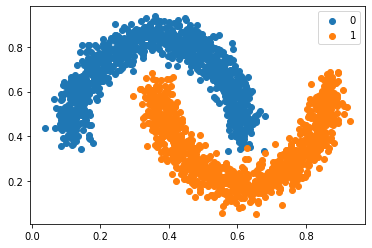

In [38]:
for label in np.unique(y_train):
    idx = np.where(y_train == label)[0]
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=label)
plt.legend()
plt.show()

In [39]:
def brute_predict(model, X):
    """ Otherwise, predict doesn't work with modified activations """
    for layer in model.layers:
        X = layer(X)
    return X.numpy()

def model2internal_rep(model, X, decision_boundary=False):
    """Note, for now this assumes binary classification due to the decision boundary"""
    internal_rep = []
    act = X
    for layer in model.layers[:-1]:
        act = layer(act)
        internal_rep.append(act != 0)
    if decision_boundary:
        act = model.layers[-1](act)
        internal_rep.append(act.numpy().argmax(axis=1).reshape(-1, 1))
        decision_rep = np.hstack(internal_rep).astype(int)
        internal_rep = np.hstack(internal_rep[:-1]).astype(int)
        return internal_rep, decision_rep
    else:
        internal_rep = np.hstack(internal_rep).astype(int)
        return internal_rep

def plot_decision_boundaries(model, X, y, xlim=None, ylim=None, n_pts=100, title=None, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.scatter(*list(zip(*X)), c=y, cmap='RdBu', alpha=0.25)

    # plot the decision function
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0]-0.5, xlim[1]+0.5, n_pts)
    yy = np.linspace(ylim[0]-0.5, ylim[1]+0.5, n_pts)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    # plot linear region boundaries
    # activations = polytope_membership(model, XY)
    colors = ['red', 'blue', 'black']
    internal_rep = model2internal_rep(model, XY)

    for relu_i in range(internal_rep.shape[1]):
        # Z = np.unique(internal_rep, axis=0, return_inverse=True)[1].reshape(XX.shape)
        Z = internal_rep[:, relu_i].reshape(XX.shape)
        CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)
    CS.collections[0].set_label('ReLU hyperplanes')
    
    predictions = np.argmax(brute_predict(model, XY), axis=1)
    Z_pred = predictions.reshape(XX.shape)
    CS = plt.contour(XX, YY, Z_pred, colors='black', alpha=1, linestyles='--')
    CS.collections[0].set_label('Softmax decision')

    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [40]:
# To remove relu by deleting output
class CustomConnected(tf.keras.layers.Dense):
    def __init__(self, units, connections=None, activations=None, **kwargs):

        #this is matrix A
        self.connections = connections  
        if activations is not None and type(activations) is not list:
            if type(activations) == str:
                self.activations = [tf.keras.activations.get(activations)] * units
            else:
                self.activations = [activations] * units
        else:
            self.activations = activations

        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activations is not None:
            slices = tf.unstack(output, axis=1)
            activated = []
            for s, act in zip(slices, self.activations):
                activated.append(act(s))
            output = tf.stack(activated, axis=1)
        elif self.activation is not None:
            output = self.activation(output)
        
        if self.connections is not None:
            output = tf.matmul(output, self.connections)
        
        return output
    
def zero_activation(X):
    return X*0

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

saved_models = []

optimizer = tf.keras.optimizers.Adam(0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[metric],
)

xlim=[-3, 4]; ylim=[-3, 4]
n_epochs = 150
print(f"Fit model on training data, n_epochs {n_epochs}")

activated_regions = []
activated_decision_regions = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=1,
        validation_data=(X_test, y_test),
    )
    internal_rep, decision_rep = model2internal_rep(model, X_train, decision_boundary=True)
    n_activated_regions = np.unique(internal_rep, axis=0).shape[0]
    activated_regions.append(n_activated_regions)
    activated_decision_regions.append(np.unique(decision_rep, axis=0).shape[0])
    test_accuracy = history.history['val_sparse_categorical_accuracy'][0]
    test_accuracies.append(test_accuracy)
    train_accuracies.append(history.history['sparse_categorical_accuracy'][0])
    title = f'Epoch={epoch}, Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}'
#     if epochs in list(range(0, 22, 2)) + list(range(20, n_epochs+10, 5)):
#         plot_decision_boundaries(
#             model, X_train, y_train, n_pts=500,
#             xlim=xlim, ylim=ylim,
#             title=title,
#             save_path=f'./results/spiral_training_epochs/spiral_layers=2_training_hyperplanes_epoch={epoch}.png'
#         )

Fit model on training data, n_epochs 150
63/63 [==============================] - 0s 2ms/step - loss: 0.2649 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.2872 - val_sparse_categorical_accuracy: 0.8715


63/63 [==============================] - 0s 2ms/step - loss: 0.2631 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.2638 - val_sparse_categorical_accuracy: 0.8795


63/63 [==============================] - 0s 2ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.0191 - val_sparse_categorical_accuracy: 0.9970


63/63 [==============================] - 0s 3ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.0146 - val_sparse_categorical_accuracy: 0.9975


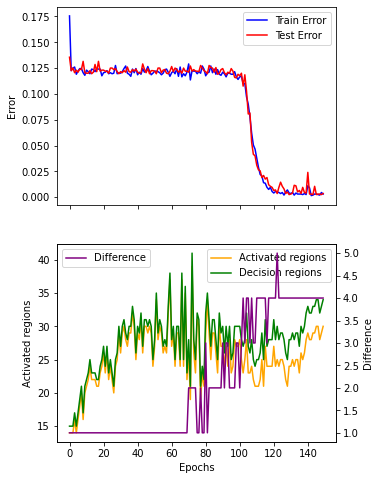

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
ax = axes[0]
ax.plot(np.arange(n_epochs), 1-np.asarray(train_accuracies), c='blue', label='Train Error')
ax.plot(np.arange(n_epochs), 1-np.asarray(test_accuracies), c='red', label='Test Error')
ax.set_ylabel('Error')
ax.legend()
ax = axes[1]
ax.plot(np.arange(n_epochs), activated_regions, label='Activated regions', c='orange')
ax.plot(np.arange(n_epochs), activated_decision_regions, label='Decision regions', c='green')
ax.legend()
ax.set_ylabel('Activated regions')
ax.set_xlabel('Epochs')
ax = ax.twinx()
ax.plot(np.arange(n_epochs), np.asarray(activated_decision_regions) - np.asarray(activated_regions), label='Difference', c='purple')
ax.legend()
ax.set_ylabel('Difference')
ax.legend()
plt.show()

Fit model on training data, n_epochs 100
63/63 [==============================] - 1s 9ms/step - loss: 0.5311 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.2828 - val_sparse_categorical_accuracy: 0.8660


<ipython-input-9-db6b2c4ece2d>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


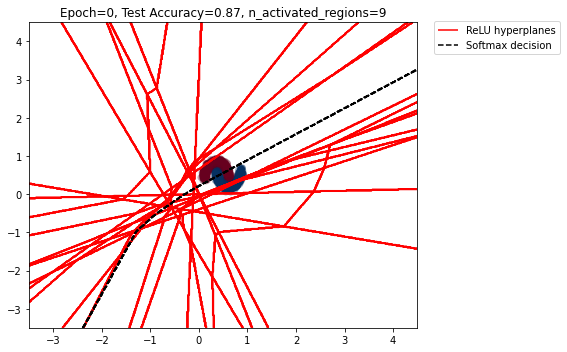

63/63 [==============================] - 0s 3ms/step - loss: 0.2747 - sparse_categorical_accuracy: 0.8720 - val_loss: 0.3098 - val_sparse_categorical_accuracy: 0.8610


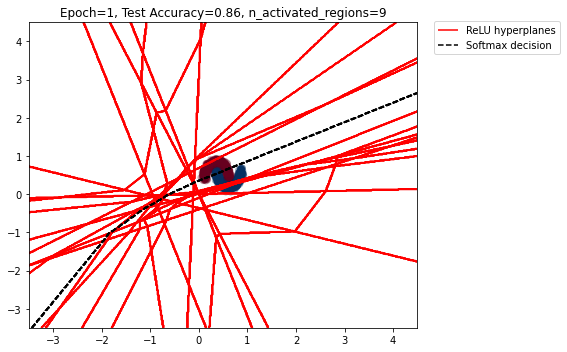

63/63 [==============================] - 0s 3ms/step - loss: 0.2637 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.2629 - val_sparse_categorical_accuracy: 0.8810


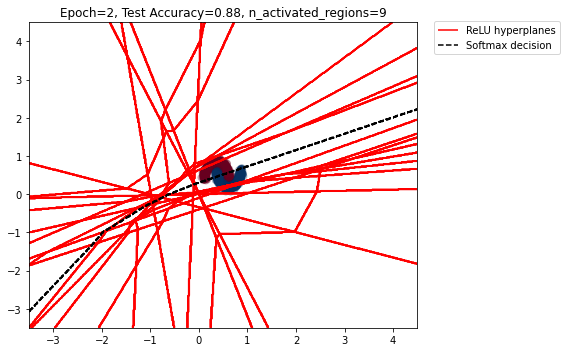

63/63 [==============================] - 0s 3ms/step - loss: 0.2659 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.2624 - val_sparse_categorical_accuracy: 0.8795


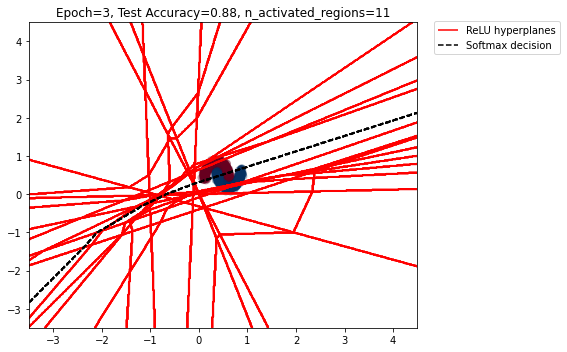

63/63 [==============================] - 0s 3ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.8805 - val_loss: 0.2707 - val_sparse_categorical_accuracy: 0.8785


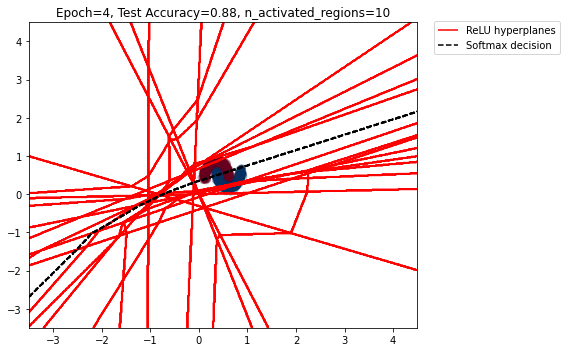

63/63 [==============================] - 0s 3ms/step - loss: 0.2636 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.2627 - val_sparse_categorical_accuracy: 0.8775


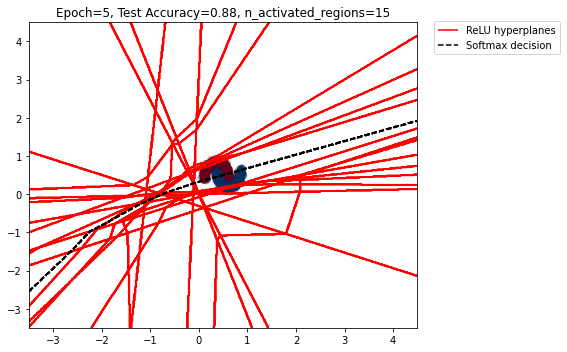

63/63 [==============================] - 0s 3ms/step - loss: 0.2590 - sparse_categorical_accuracy: 0.8795 - val_loss: 0.2711 - val_sparse_categorical_accuracy: 0.8765


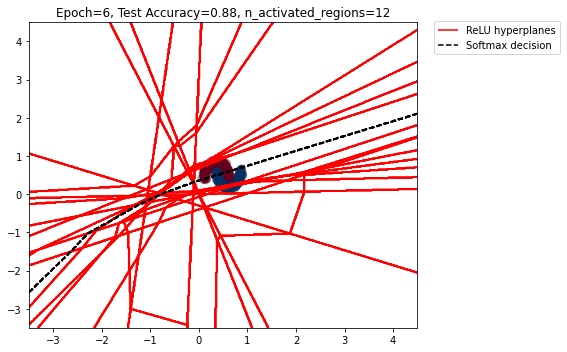

63/63 [==============================] - 0s 3ms/step - loss: 0.2600 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.2662 - val_sparse_categorical_accuracy: 0.8780


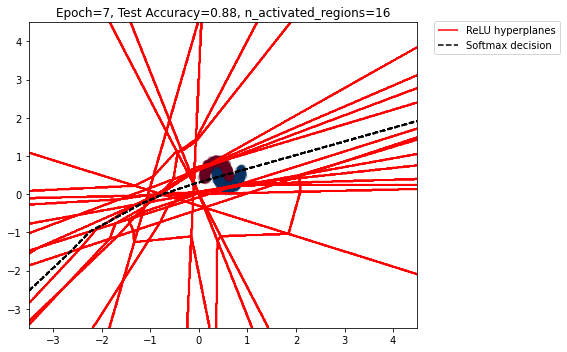

63/63 [==============================] - 0s 3ms/step - loss: 0.2571 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.2715 - val_sparse_categorical_accuracy: 0.8755


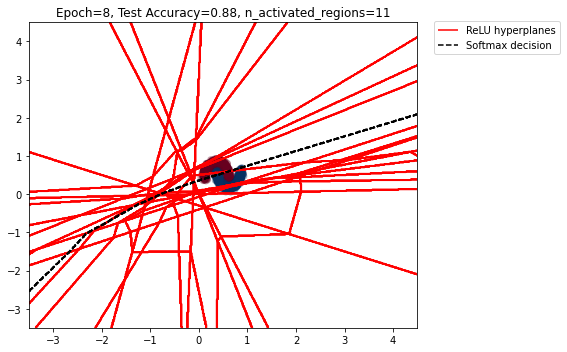

63/63 [==============================] - 0s 3ms/step - loss: 0.2570 - sparse_categorical_accuracy: 0.8795 - val_loss: 0.2794 - val_sparse_categorical_accuracy: 0.8745


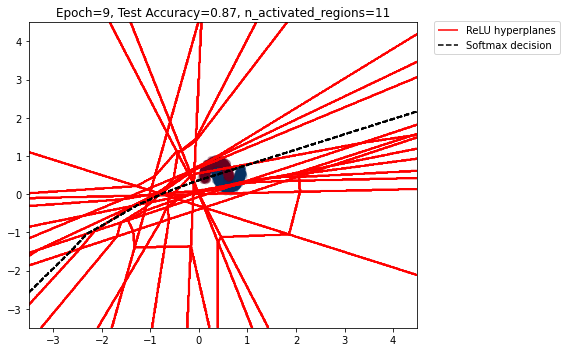

63/63 [==============================] - 0s 3ms/step - loss: 0.2629 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.2649 - val_sparse_categorical_accuracy: 0.8775


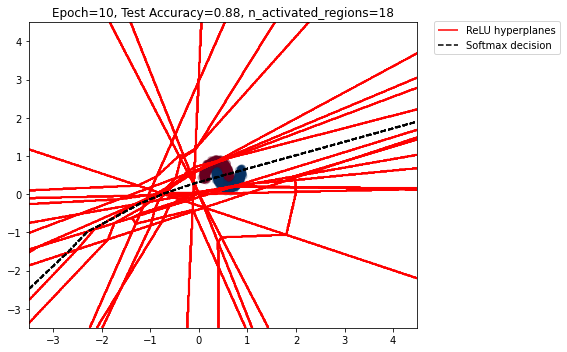

63/63 [==============================] - 0s 3ms/step - loss: 0.2608 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.3224 - val_sparse_categorical_accuracy: 0.8530


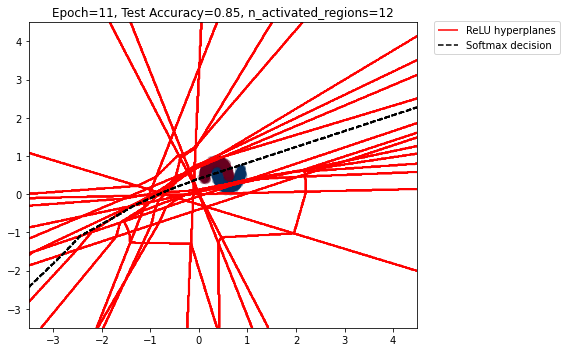

63/63 [==============================] - 0s 3ms/step - loss: 0.2657 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.2624 - val_sparse_categorical_accuracy: 0.8790


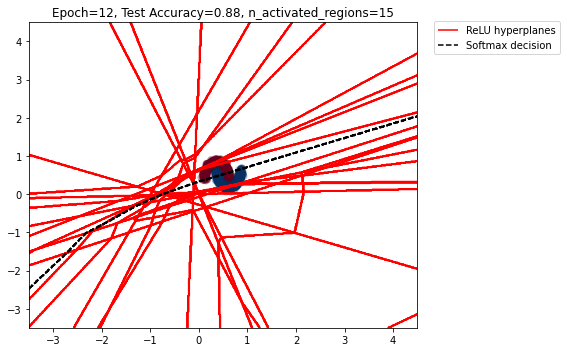

63/63 [==============================] - 0s 3ms/step - loss: 0.2573 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.2797 - val_sparse_categorical_accuracy: 0.8745


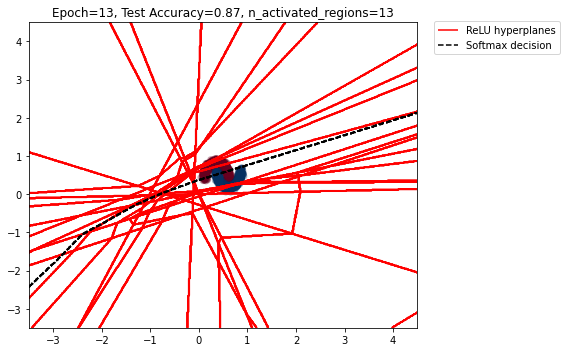

63/63 [==============================] - 0s 3ms/step - loss: 0.2564 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.2618 - val_sparse_categorical_accuracy: 0.8800


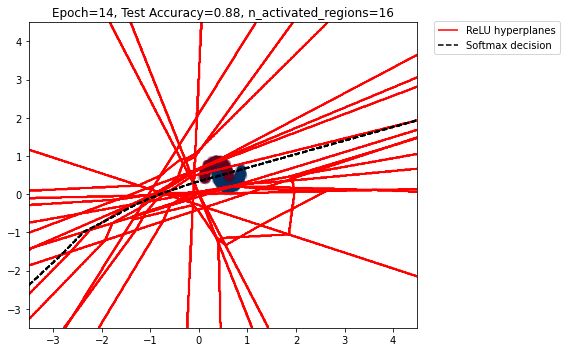

63/63 [==============================] - 0s 3ms/step - loss: 0.2651 - sparse_categorical_accuracy: 0.8735 - val_loss: 0.2622 - val_sparse_categorical_accuracy: 0.8790


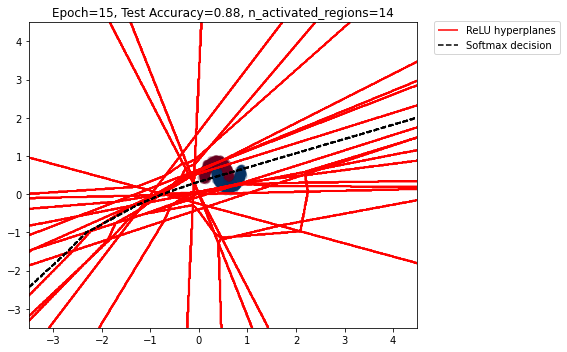

63/63 [==============================] - 0s 3ms/step - loss: 0.2584 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.2679 - val_sparse_categorical_accuracy: 0.8785


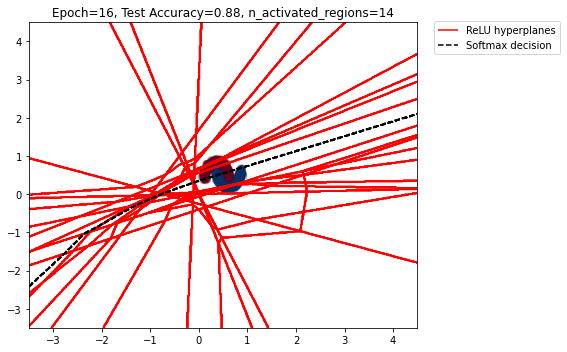

63/63 [==============================] - 0s 3ms/step - loss: 0.2568 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.2635 - val_sparse_categorical_accuracy: 0.8780


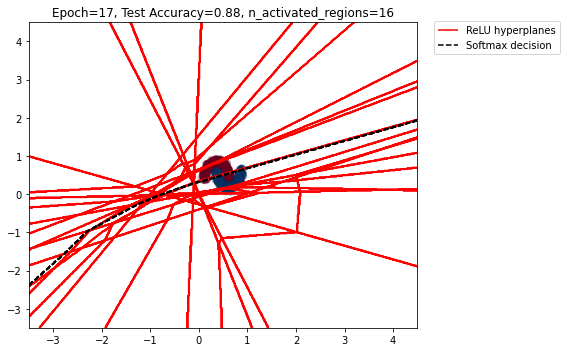

63/63 [==============================] - 0s 3ms/step - loss: 0.2627 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.2626 - val_sparse_categorical_accuracy: 0.8795


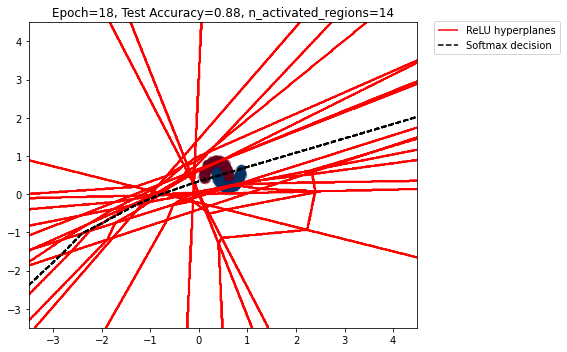

63/63 [==============================] - 0s 3ms/step - loss: 0.2557 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.2620 - val_sparse_categorical_accuracy: 0.8805


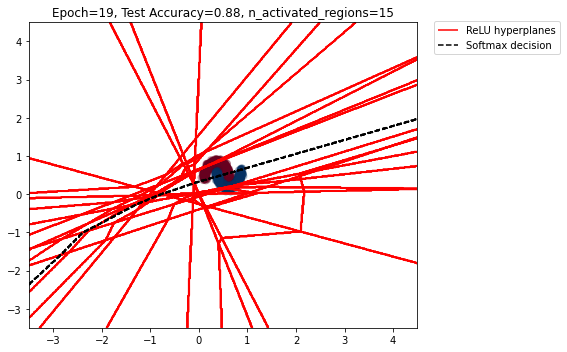

63/63 [==============================] - 0s 3ms/step - loss: 0.2596 - sparse_categorical_accuracy: 0.8805 - val_loss: 0.2624 - val_sparse_categorical_accuracy: 0.8790


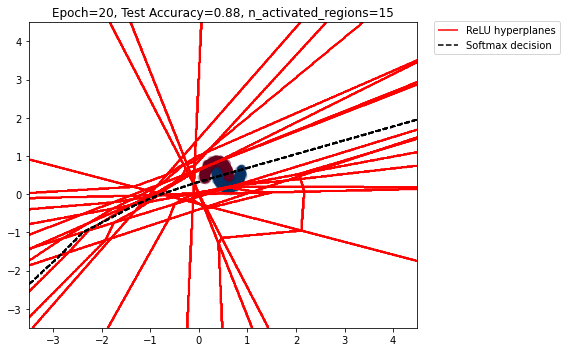

63/63 [==============================] - 0s 3ms/step - loss: 0.2628 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.2914 - val_sparse_categorical_accuracy: 0.8690


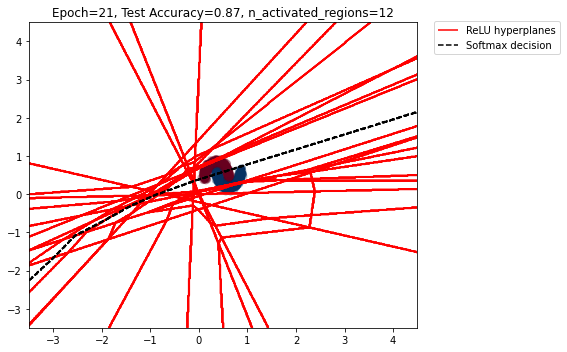

63/63 [==============================] - 0s 3ms/step - loss: 0.2694 - sparse_categorical_accuracy: 0.8745 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.8775


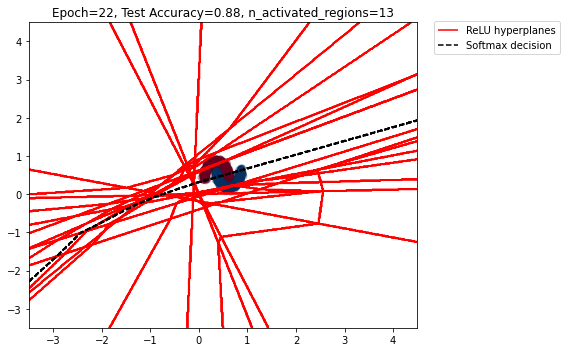

63/63 [==============================] - 0s 3ms/step - loss: 0.2604 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.2631 - val_sparse_categorical_accuracy: 0.8795


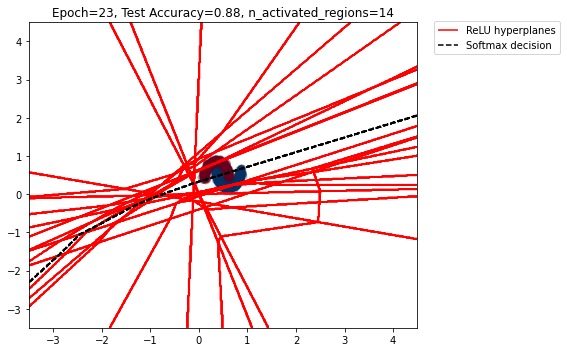

63/63 [==============================] - 0s 3ms/step - loss: 0.2569 - sparse_categorical_accuracy: 0.8850 - val_loss: 0.2650 - val_sparse_categorical_accuracy: 0.8770


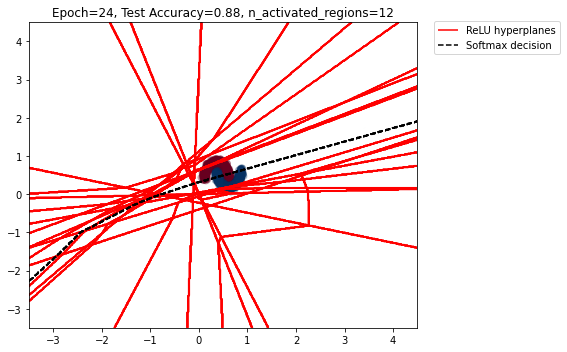

63/63 [==============================] - 0s 3ms/step - loss: 0.2625 - sparse_categorical_accuracy: 0.8720 - val_loss: 0.2629 - val_sparse_categorical_accuracy: 0.8795


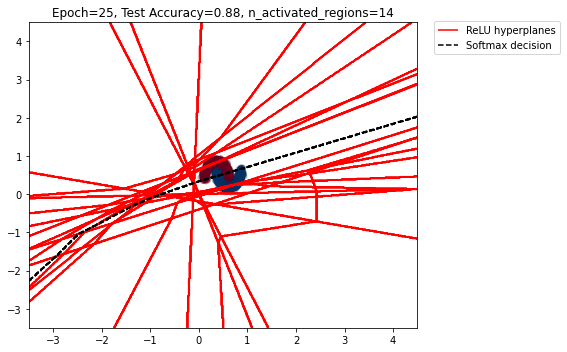

63/63 [==============================] - 0s 3ms/step - loss: 0.2610 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.2625 - val_sparse_categorical_accuracy: 0.8800


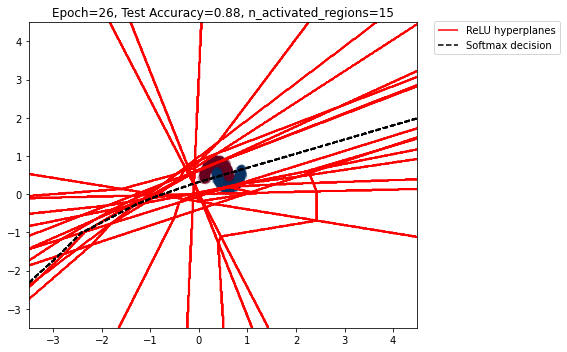

63/63 [==============================] - 0s 3ms/step - loss: 0.2545 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.2718 - val_sparse_categorical_accuracy: 0.8760


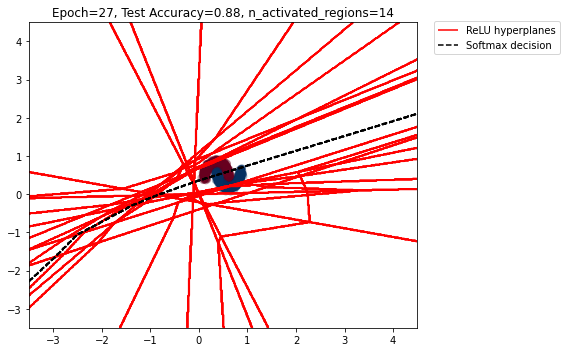

63/63 [==============================] - 0s 3ms/step - loss: 0.2680 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.2670 - val_sparse_categorical_accuracy: 0.8785


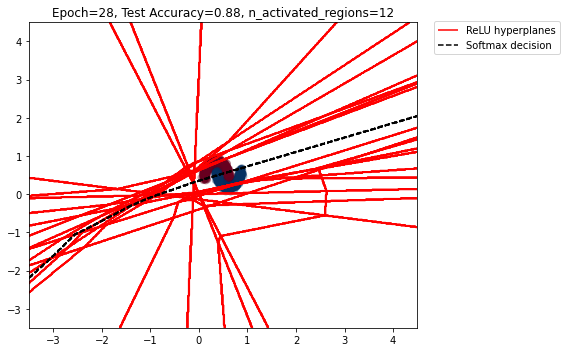

63/63 [==============================] - 0s 3ms/step - loss: 0.2601 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.2629 - val_sparse_categorical_accuracy: 0.8785


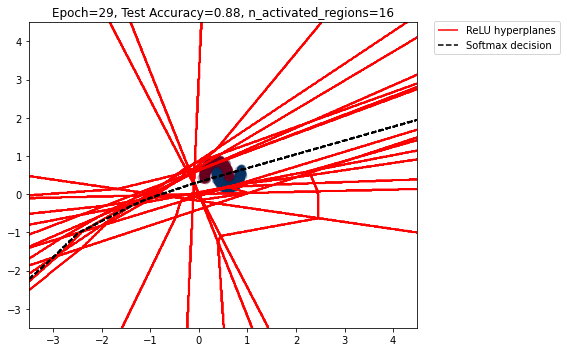

63/63 [==============================] - 0s 3ms/step - loss: 0.2570 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.2659 - val_sparse_categorical_accuracy: 0.8790


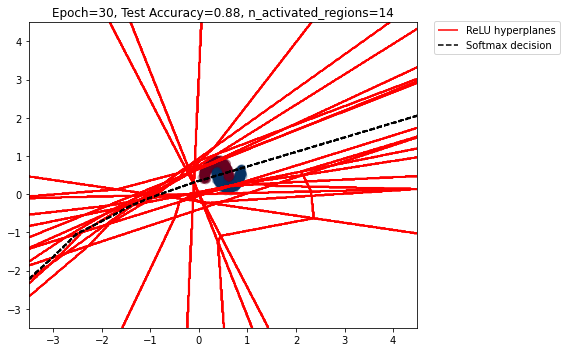

63/63 [==============================] - 0s 3ms/step - loss: 0.2622 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.2838 - val_sparse_categorical_accuracy: 0.8720


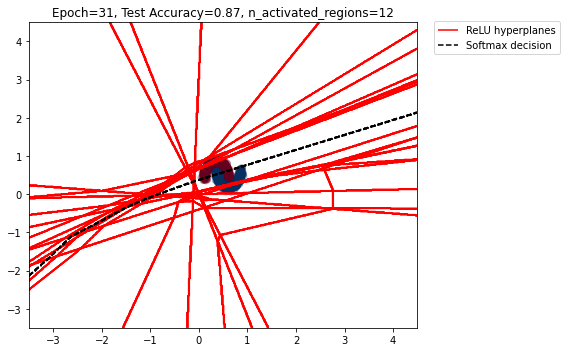

63/63 [==============================] - 0s 3ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.2629 - val_sparse_categorical_accuracy: 0.8790


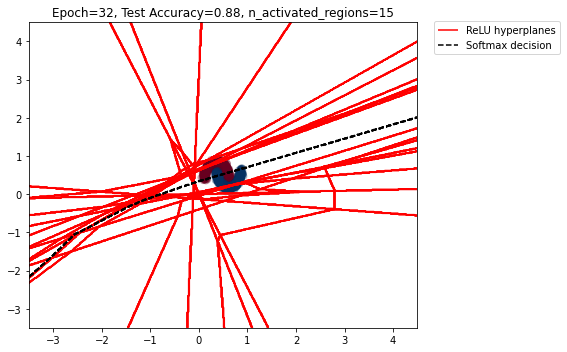

63/63 [==============================] - 0s 3ms/step - loss: 0.2575 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.2636 - val_sparse_categorical_accuracy: 0.8785


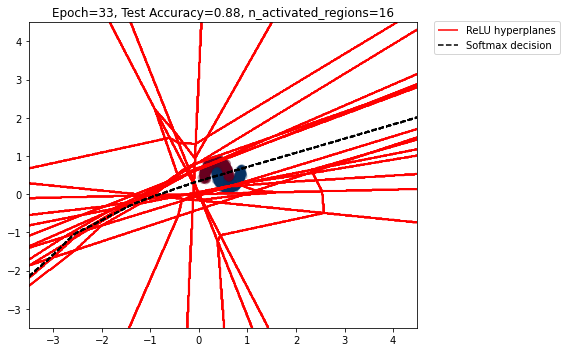

63/63 [==============================] - 0s 3ms/step - loss: 0.2549 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.2867 - val_sparse_categorical_accuracy: 0.8715


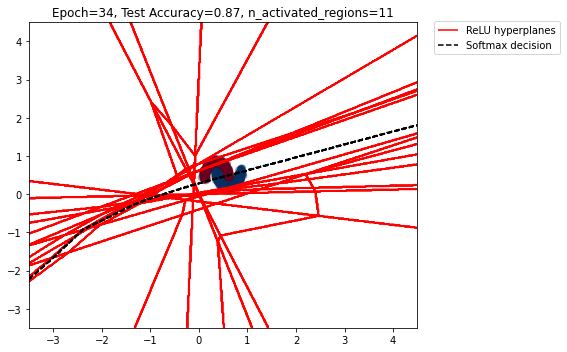

63/63 [==============================] - 0s 3ms/step - loss: 0.2664 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.2804 - val_sparse_categorical_accuracy: 0.8735


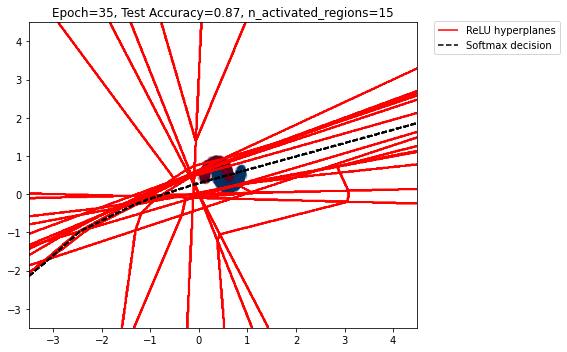

63/63 [==============================] - 0s 3ms/step - loss: 0.2595 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.2745 - val_sparse_categorical_accuracy: 0.8735


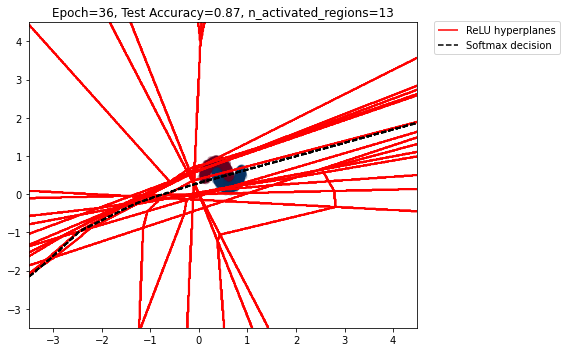

63/63 [==============================] - 0s 3ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.2628 - val_sparse_categorical_accuracy: 0.8780


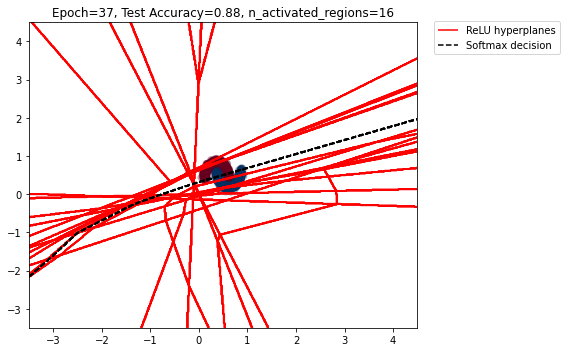

63/63 [==============================] - 0s 3ms/step - loss: 0.2561 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.2621 - val_sparse_categorical_accuracy: 0.8805


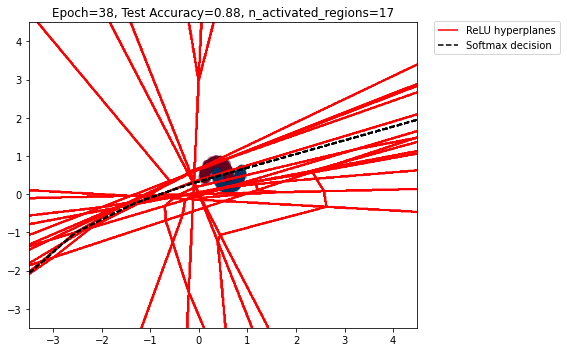

63/63 [==============================] - 0s 3ms/step - loss: 0.2593 - sparse_categorical_accuracy: 0.8805 - val_loss: 0.2601 - val_sparse_categorical_accuracy: 0.8790


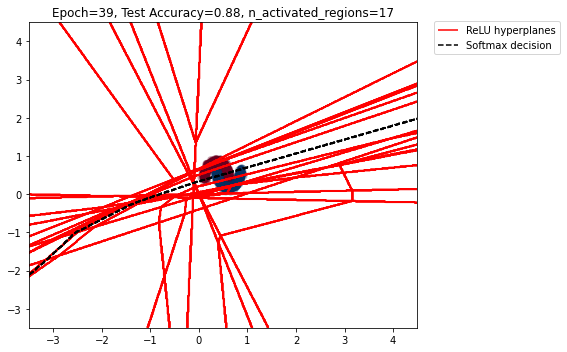

63/63 [==============================] - 0s 3ms/step - loss: 0.2611 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.2659 - val_sparse_categorical_accuracy: 0.8765


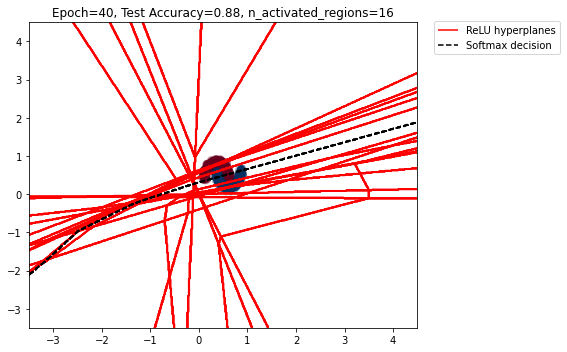

63/63 [==============================] - 0s 3ms/step - loss: 0.2529 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.2579 - val_sparse_categorical_accuracy: 0.8785


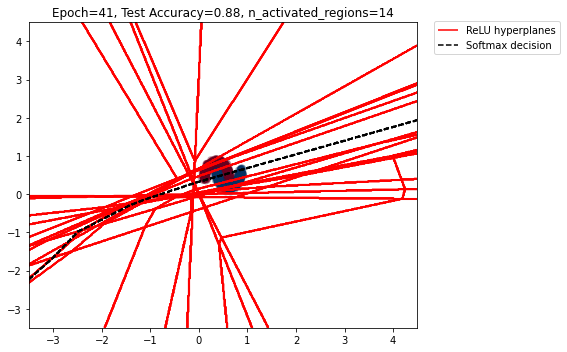

63/63 [==============================] - 0s 3ms/step - loss: 0.2560 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.2595 - val_sparse_categorical_accuracy: 0.8800


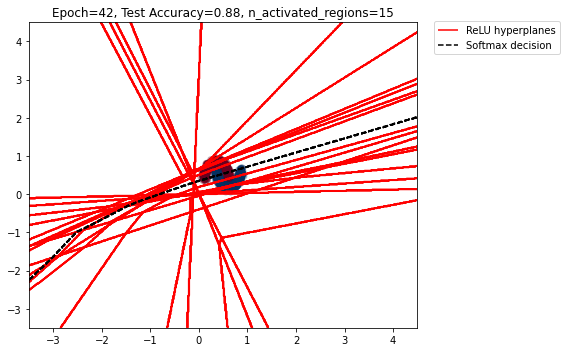

63/63 [==============================] - 0s 3ms/step - loss: 0.2520 - sparse_categorical_accuracy: 0.8855 - val_loss: 0.2591 - val_sparse_categorical_accuracy: 0.8785


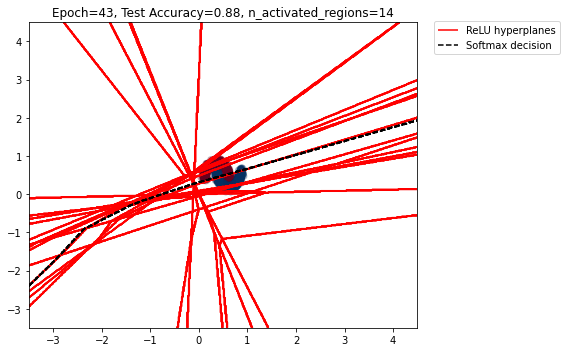

63/63 [==============================] - 0s 3ms/step - loss: 0.2531 - sparse_categorical_accuracy: 0.8830 - val_loss: 0.2545 - val_sparse_categorical_accuracy: 0.8790


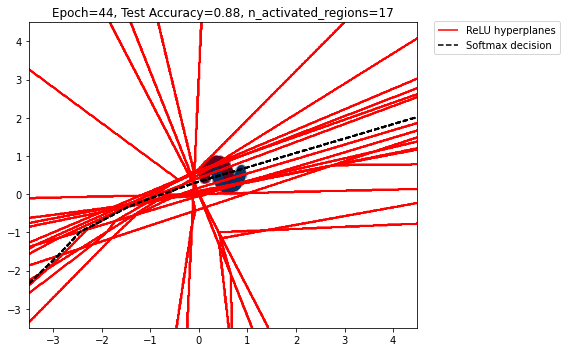

63/63 [==============================] - 0s 3ms/step - loss: 0.2482 - sparse_categorical_accuracy: 0.8845 - val_loss: 0.2612 - val_sparse_categorical_accuracy: 0.8775


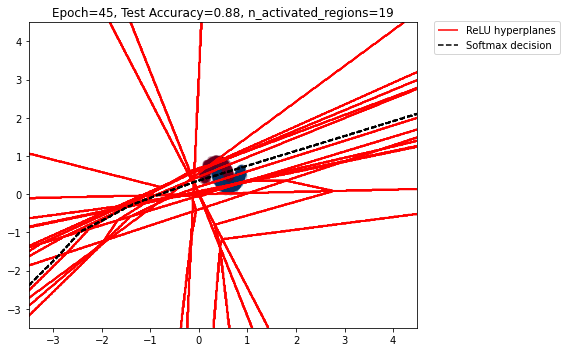

63/63 [==============================] - 0s 3ms/step - loss: 0.2523 - sparse_categorical_accuracy: 0.8745 - val_loss: 0.2536 - val_sparse_categorical_accuracy: 0.8780


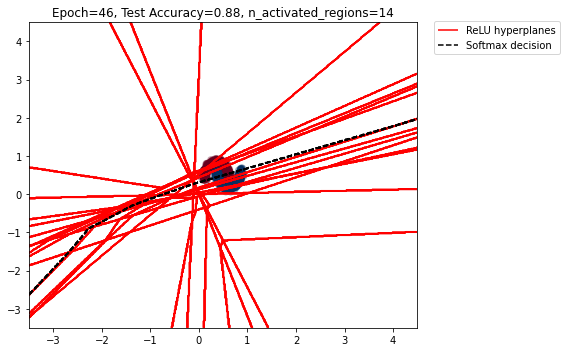

63/63 [==============================] - 0s 3ms/step - loss: 0.2512 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.2535 - val_sparse_categorical_accuracy: 0.8810


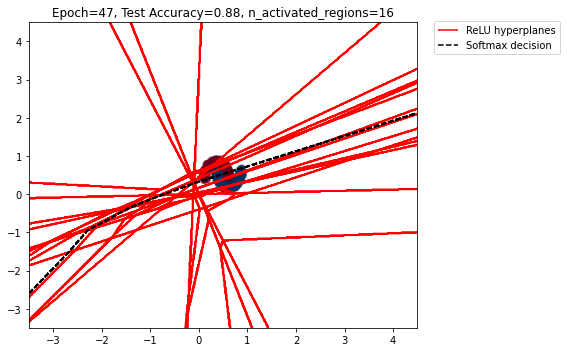

63/63 [==============================] - 0s 3ms/step - loss: 0.2502 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.2514 - val_sparse_categorical_accuracy: 0.8795


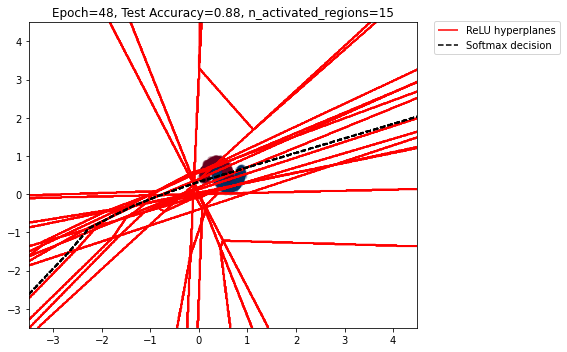

63/63 [==============================] - 0s 3ms/step - loss: 0.2477 - sparse_categorical_accuracy: 0.8805 - val_loss: 0.2621 - val_sparse_categorical_accuracy: 0.8740


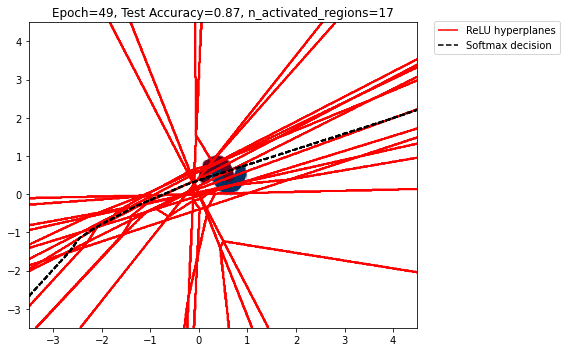

63/63 [==============================] - 0s 3ms/step - loss: 0.2451 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.2521 - val_sparse_categorical_accuracy: 0.8765


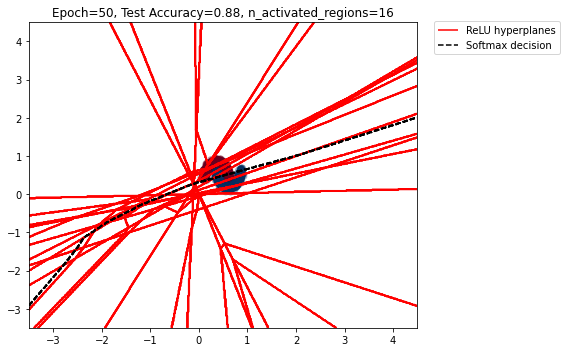

63/63 [==============================] - 0s 3ms/step - loss: 0.2415 - sparse_categorical_accuracy: 0.8835 - val_loss: 0.2482 - val_sparse_categorical_accuracy: 0.8750


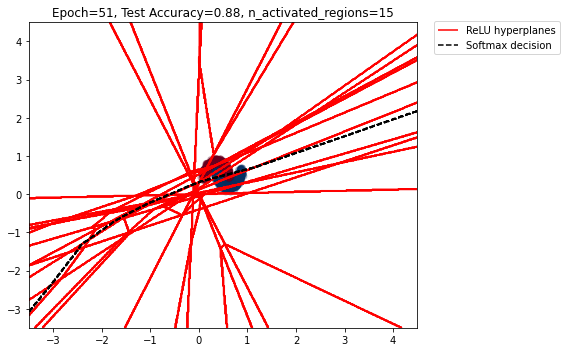

63/63 [==============================] - 0s 3ms/step - loss: 0.2410 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.2406 - val_sparse_categorical_accuracy: 0.8820


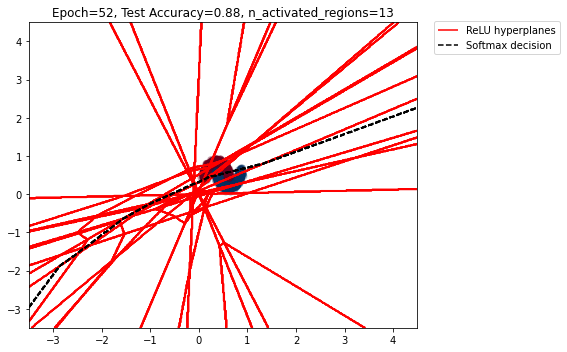

63/63 [==============================] - 0s 3ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.2342 - val_sparse_categorical_accuracy: 0.8795


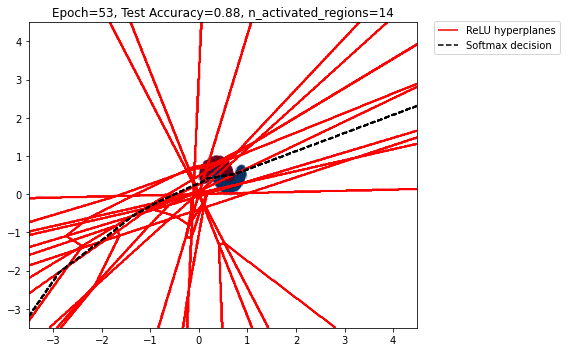

63/63 [==============================] - 0s 3ms/step - loss: 0.2313 - sparse_categorical_accuracy: 0.8895 - val_loss: 0.2337 - val_sparse_categorical_accuracy: 0.8795


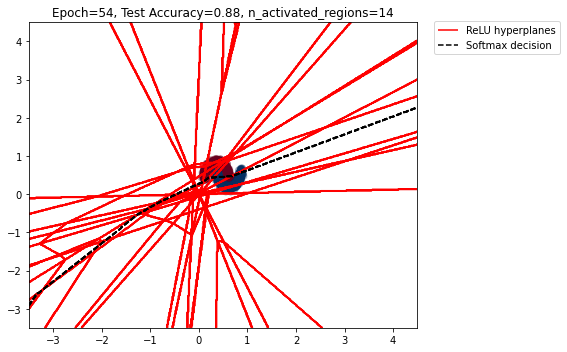

63/63 [==============================] - 0s 3ms/step - loss: 0.2148 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.2148 - val_sparse_categorical_accuracy: 0.9125


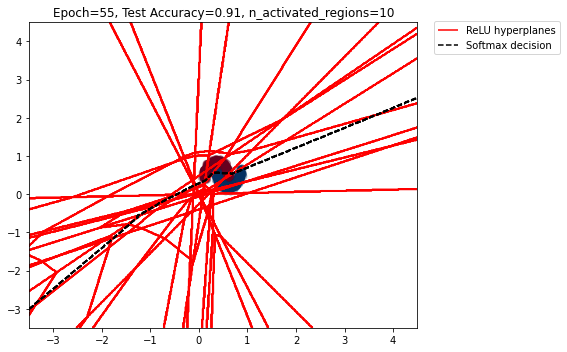

63/63 [==============================] - 0s 3ms/step - loss: 0.2062 - sparse_categorical_accuracy: 0.9215 - val_loss: 0.2060 - val_sparse_categorical_accuracy: 0.9075


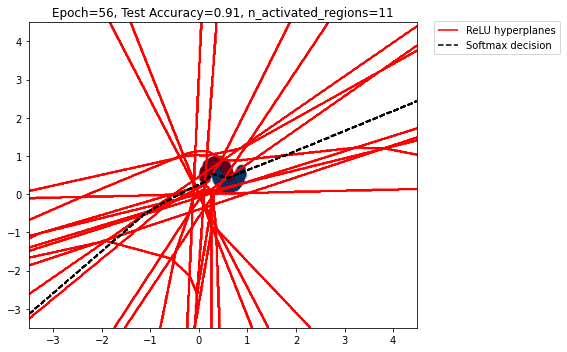

63/63 [==============================] - 0s 3ms/step - loss: 0.1888 - sparse_categorical_accuracy: 0.9285 - val_loss: 0.1663 - val_sparse_categorical_accuracy: 0.9445


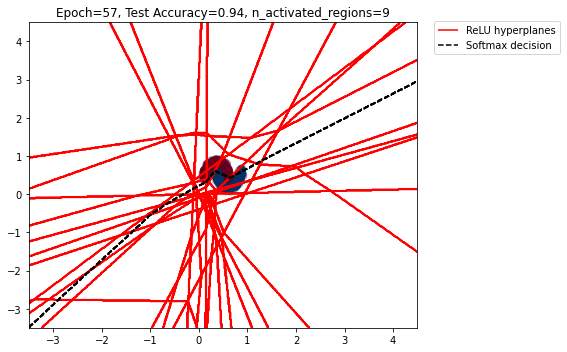

63/63 [==============================] - 0s 3ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1212 - val_sparse_categorical_accuracy: 0.9695


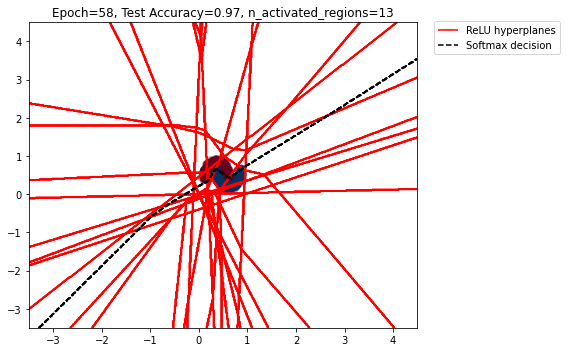

63/63 [==============================] - 0s 3ms/step - loss: 0.0974 - sparse_categorical_accuracy: 0.9755 - val_loss: 0.0733 - val_sparse_categorical_accuracy: 0.9870


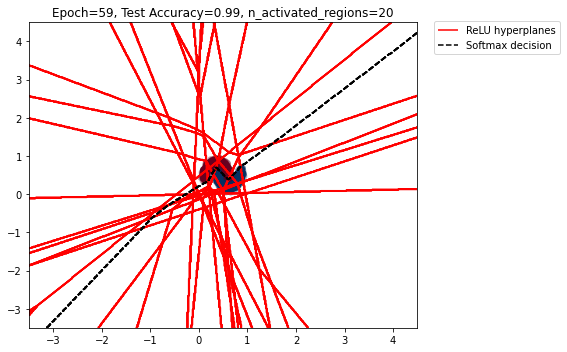

63/63 [==============================] - 0s 3ms/step - loss: 0.0568 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.0447 - val_sparse_categorical_accuracy: 0.9920


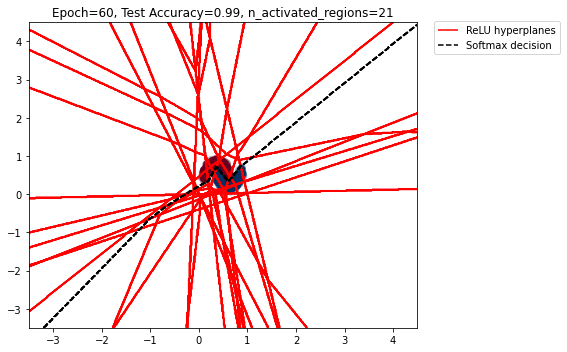

63/63 [==============================] - 0s 3ms/step - loss: 0.0367 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.0313 - val_sparse_categorical_accuracy: 0.9955


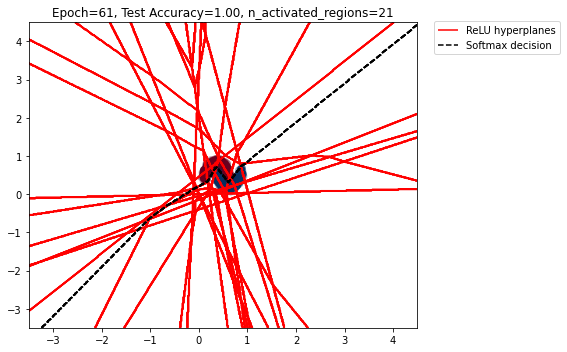

63/63 [==============================] - 0s 3ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0254 - val_sparse_categorical_accuracy: 0.9975


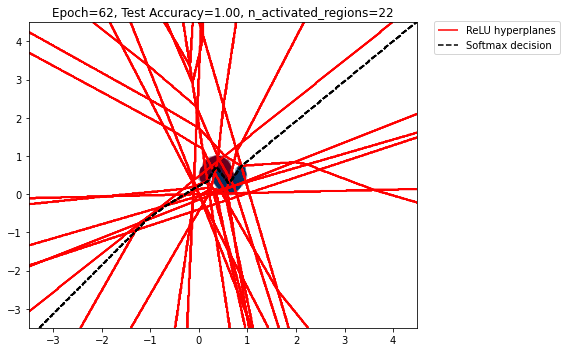

63/63 [==============================] - 0s 3ms/step - loss: 0.0206 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0272 - val_sparse_categorical_accuracy: 0.9935


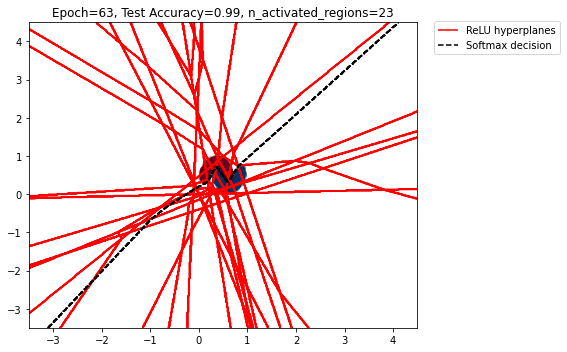

63/63 [==============================] - 0s 3ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0172 - val_sparse_categorical_accuracy: 0.9980


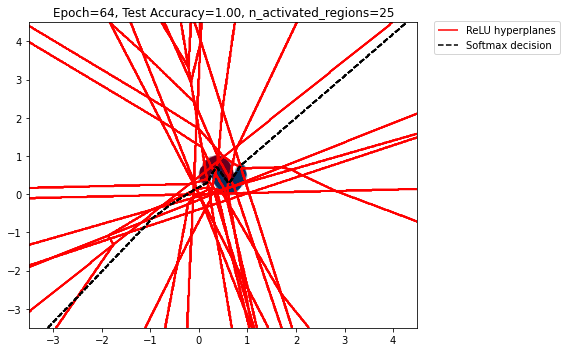

63/63 [==============================] - 0s 3ms/step - loss: 0.0157 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0225 - val_sparse_categorical_accuracy: 0.9935


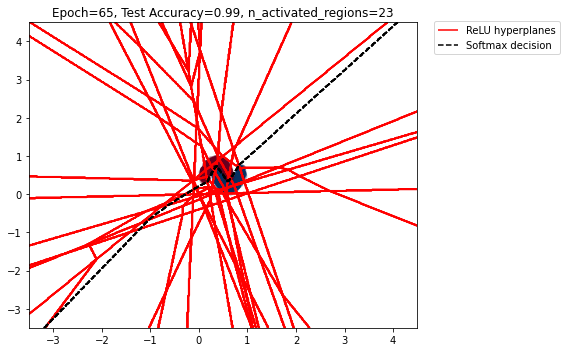

63/63 [==============================] - 0s 3ms/step - loss: 0.0148 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0164 - val_sparse_categorical_accuracy: 0.9965


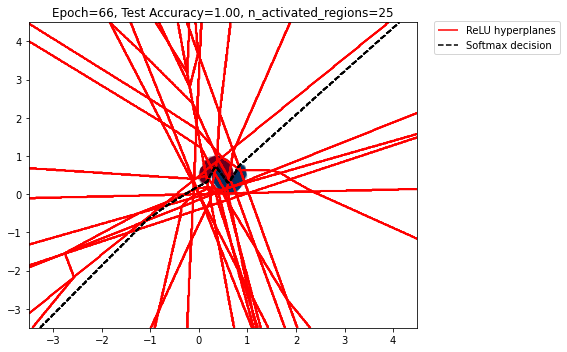

63/63 [==============================] - 0s 3ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0215 - val_sparse_categorical_accuracy: 0.9945


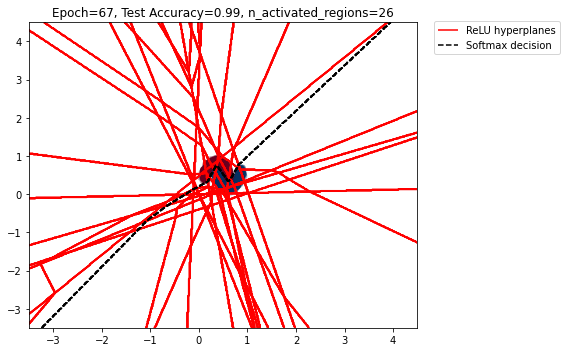

63/63 [==============================] - 0s 3ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0171 - val_sparse_categorical_accuracy: 0.9955


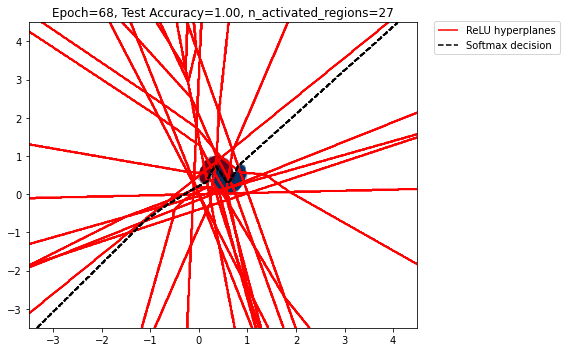

63/63 [==============================] - 0s 3ms/step - loss: 0.0115 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0126 - val_sparse_categorical_accuracy: 0.9975


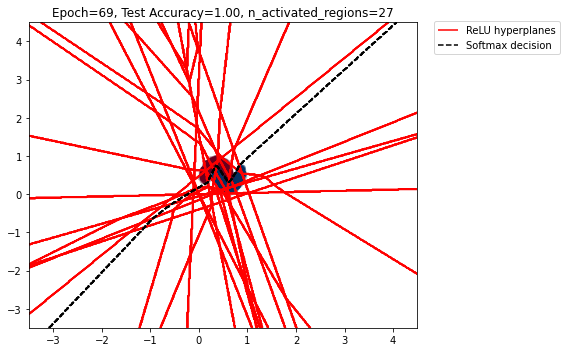

63/63 [==============================] - 0s 3ms/step - loss: 0.0124 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0167 - val_sparse_categorical_accuracy: 0.9950


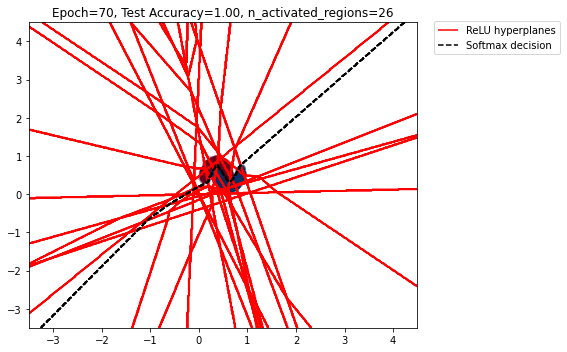

63/63 [==============================] - 0s 3ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0148 - val_sparse_categorical_accuracy: 0.9955


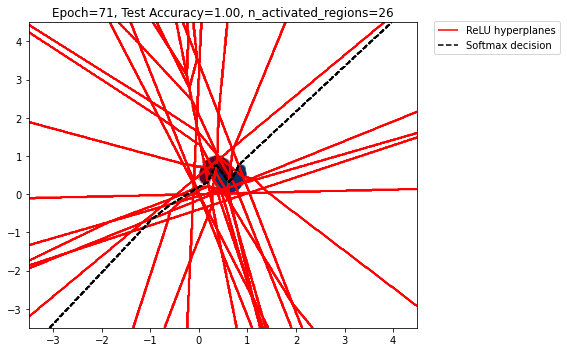

63/63 [==============================] - 0s 3ms/step - loss: 0.0101 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.0100 - val_sparse_categorical_accuracy: 0.9975


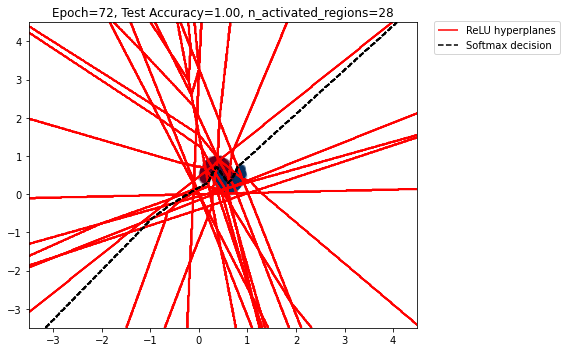

63/63 [==============================] - 0s 3ms/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0176 - val_sparse_categorical_accuracy: 0.9960


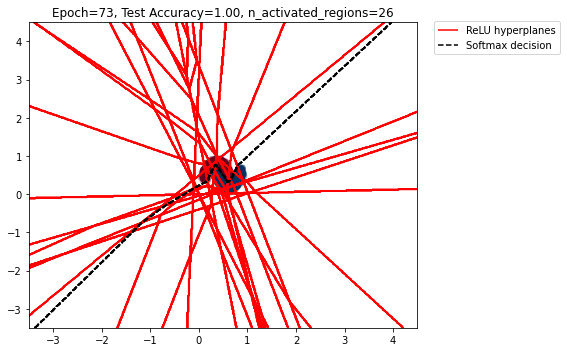

63/63 [==============================] - 0s 3ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0110 - val_sparse_categorical_accuracy: 0.9970


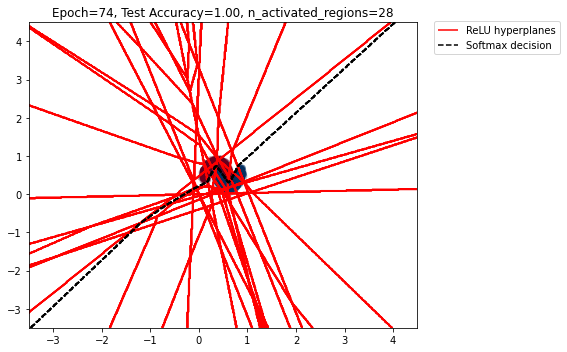

63/63 [==============================] - 0s 3ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 0.9980


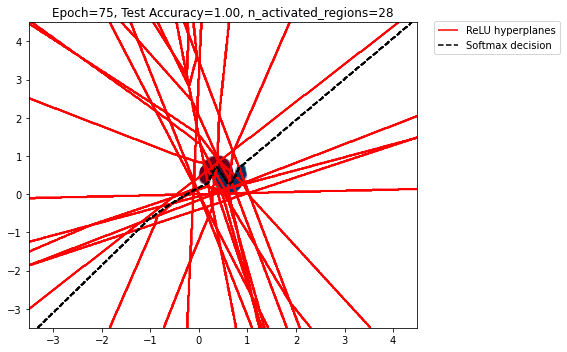

63/63 [==============================] - 0s 3ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0219 - val_sparse_categorical_accuracy: 0.9930


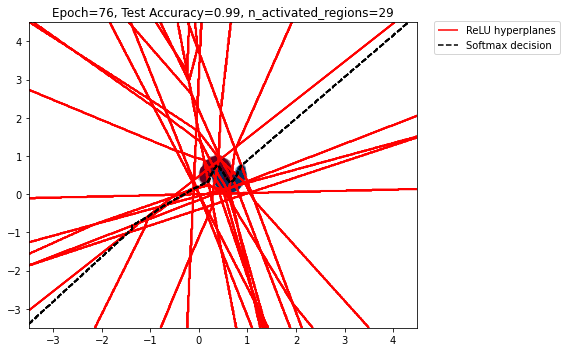

63/63 [==============================] - 0s 3ms/step - loss: 0.0149 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0078 - val_sparse_categorical_accuracy: 0.9980


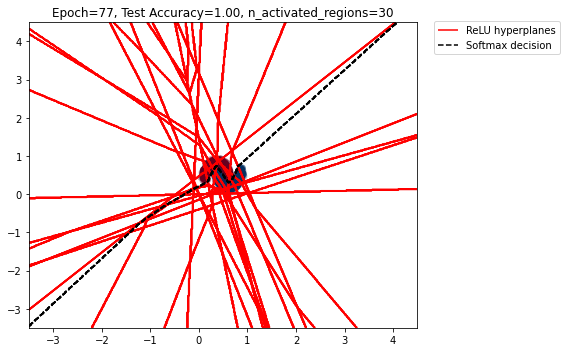

63/63 [==============================] - 0s 3ms/step - loss: 0.0093 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0206 - val_sparse_categorical_accuracy: 0.9935


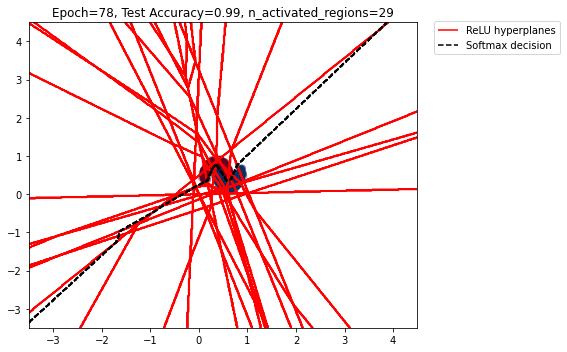

63/63 [==============================] - 0s 3ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0200 - val_sparse_categorical_accuracy: 0.9920


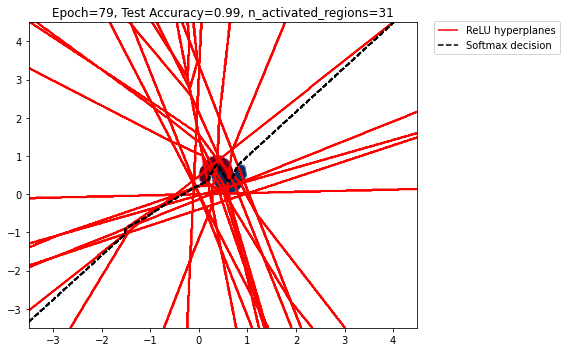

63/63 [==============================] - 0s 3ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0117 - val_sparse_categorical_accuracy: 0.9965


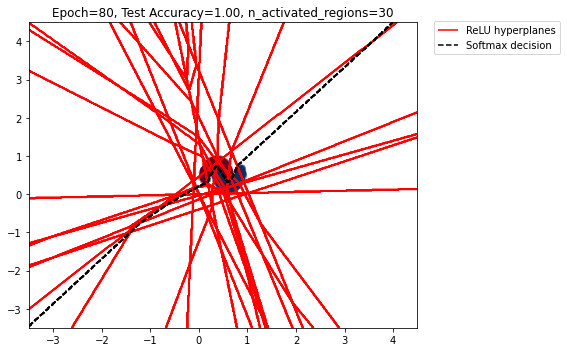

63/63 [==============================] - 0s 3ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0123 - val_sparse_categorical_accuracy: 0.9965


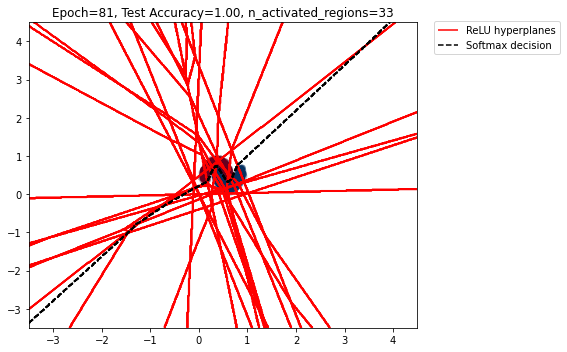

63/63 [==============================] - 0s 3ms/step - loss: 0.0071 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0109 - val_sparse_categorical_accuracy: 0.9975


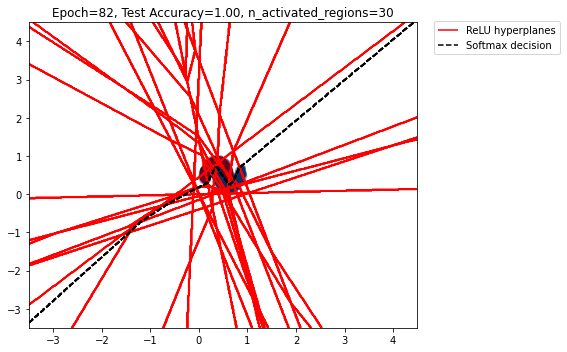

63/63 [==============================] - 0s 3ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.0242 - val_sparse_categorical_accuracy: 0.9900


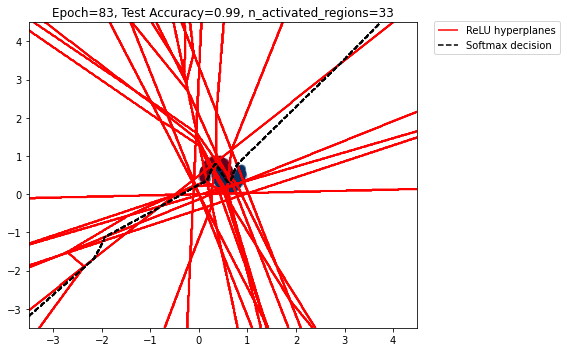

63/63 [==============================] - 0s 3ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0065 - val_sparse_categorical_accuracy: 0.9980


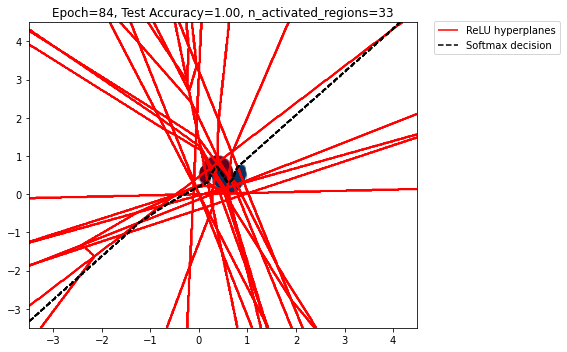

63/63 [==============================] - 0s 3ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.0296 - val_sparse_categorical_accuracy: 0.9900


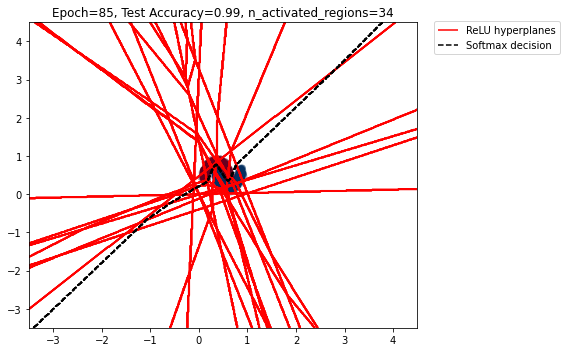

63/63 [==============================] - 0s 3ms/step - loss: 0.0072 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.0088 - val_sparse_categorical_accuracy: 0.9970


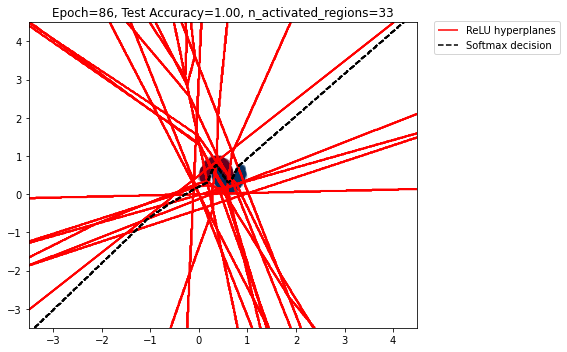

63/63 [==============================] - 0s 3ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0117 - val_sparse_categorical_accuracy: 0.9960


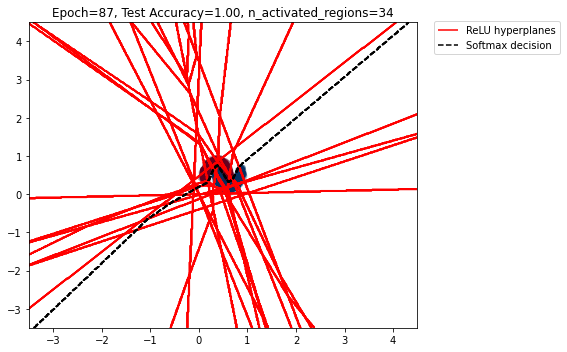

63/63 [==============================] - 0s 3ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0172 - val_sparse_categorical_accuracy: 0.9925


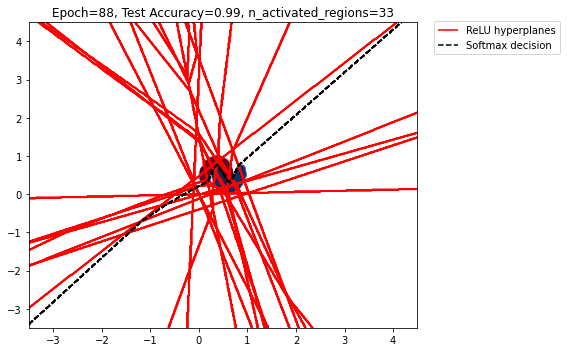

63/63 [==============================] - 0s 3ms/step - loss: 0.0112 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0067 - val_sparse_categorical_accuracy: 0.9985


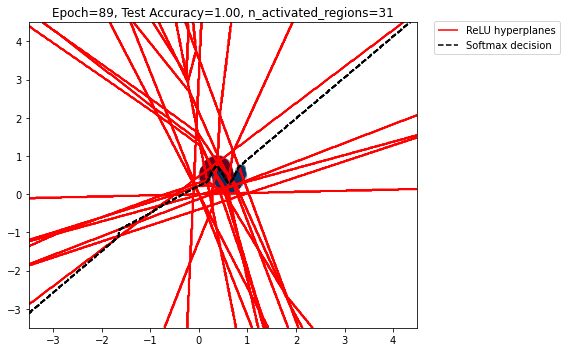

63/63 [==============================] - 0s 3ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0160 - val_sparse_categorical_accuracy: 0.9950


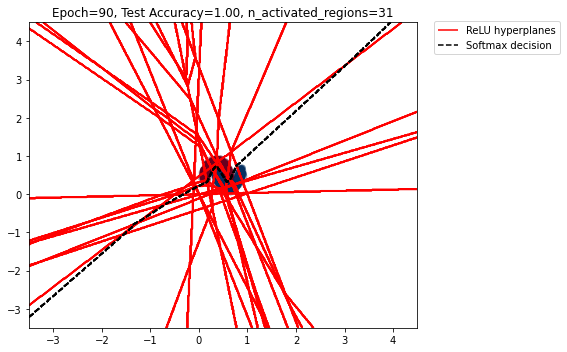

63/63 [==============================] - 0s 3ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0073 - val_sparse_categorical_accuracy: 0.9985


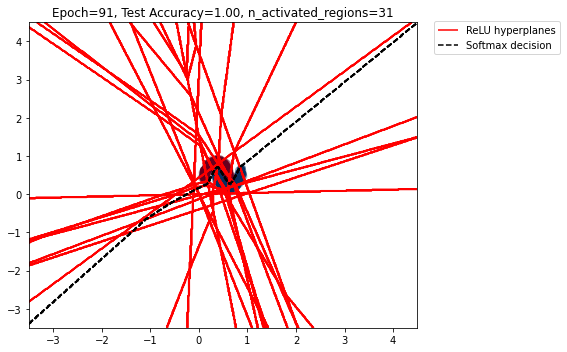

63/63 [==============================] - 0s 3ms/step - loss: 0.0059 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0085 - val_sparse_categorical_accuracy: 0.9970


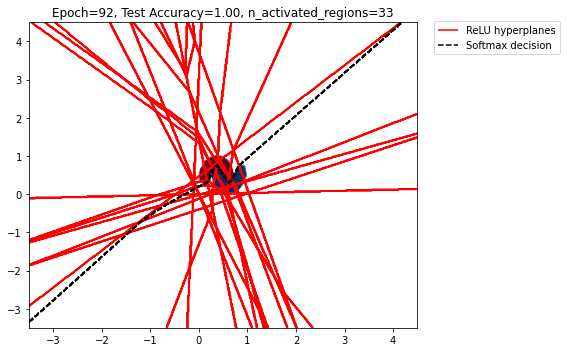

63/63 [==============================] - 0s 3ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0070 - val_sparse_categorical_accuracy: 0.9980


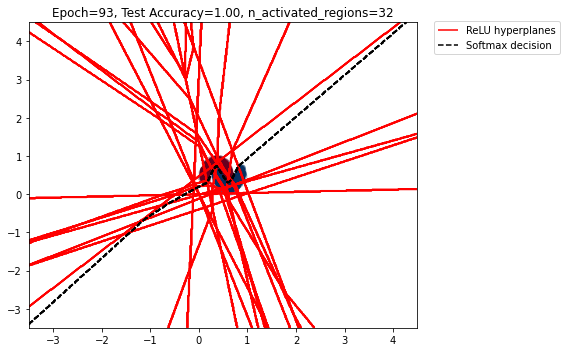

63/63 [==============================] - 0s 3ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0063 - val_sparse_categorical_accuracy: 0.9985


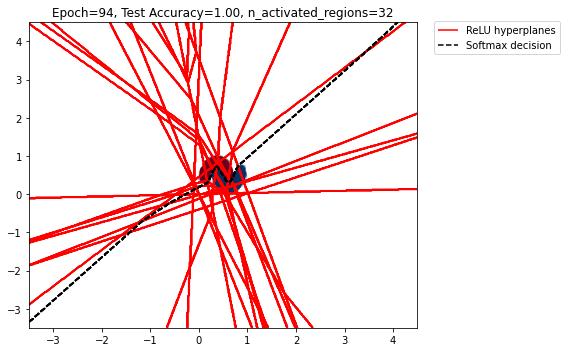

63/63 [==============================] - 0s 3ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0049 - val_sparse_categorical_accuracy: 0.9990


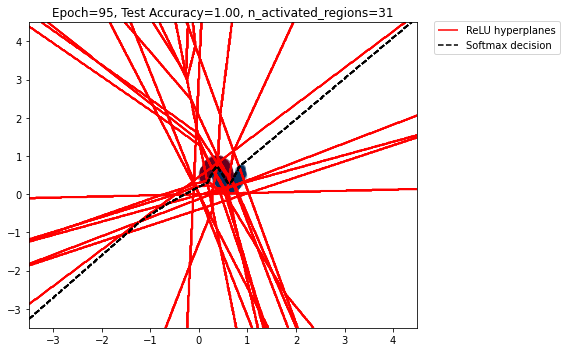

63/63 [==============================] - 0s 3ms/step - loss: 0.0084 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0086 - val_sparse_categorical_accuracy: 0.9970


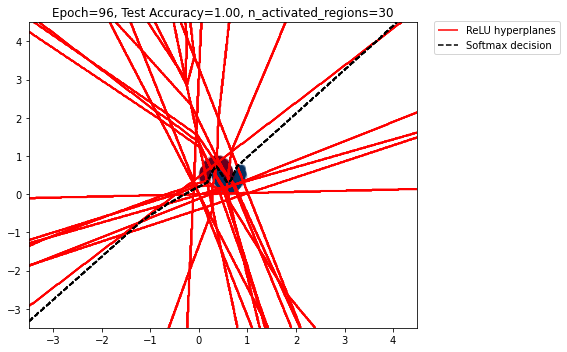

63/63 [==============================] - 0s 3ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0180 - val_sparse_categorical_accuracy: 0.9930


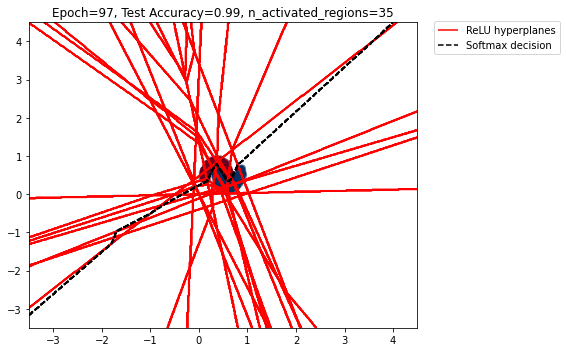

63/63 [==============================] - 0s 3ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0056 - val_sparse_categorical_accuracy: 0.9980


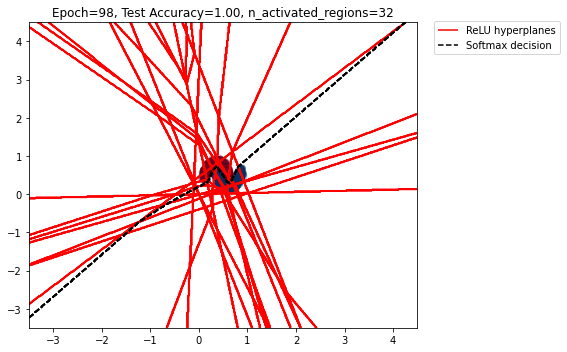

63/63 [==============================] - 0s 3ms/step - loss: 0.0067 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0053 - val_sparse_categorical_accuracy: 0.9985


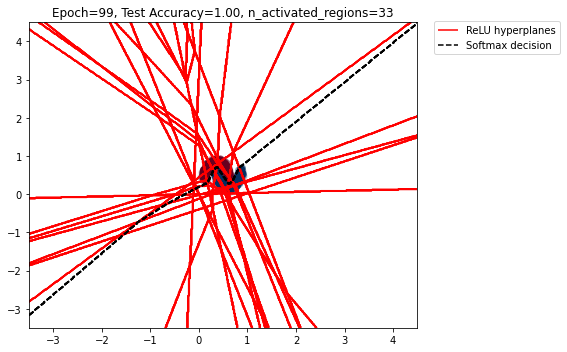

In [102]:
model = tf.keras.models.Sequential([
    tf.keras.Dense(10, activations='relu'),
    tf.keras.Dense(10, activations='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

saved_models = []

optimizer = tf.keras.optimizers.Adam(0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[metric],
)

xlim=[-3, 4]; ylim=[-3, 4]
n_epochs = 100
print(f"Fit model on training data, n_epochs {n_epochs}")

regions = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=1,
        validation_data=(X_test, y_test),
    )
    internal_rep = model2internal_rep(model, X_train)
    n_activated_regions = np.unique(internal_rep, axis=0).shape[0]
    regions.append(n_activated_regions)
    test_accuracy = history.history['val_sparse_categorical_accuracy'][0]
    test_accuracies.append(test_accuracy)
    train_accuracies.append(history.history['sparse_categorical_accuracy'][0])
    title = f'Epoch={epoch}, Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}'
    if epochs in list(range(0, 22, 2)) + list(range(20, n_epochs+10, 5)):
        plot_decision_boundaries(
            model, X_train, y_train, n_pts=500,
            xlim=xlim, ylim=ylim,
            title=title,
            save_path=f'./results/spiral_training_epochs/spiral_layers=2_training_hyperplanes_epoch={epoch}.png'
        )

<ipython-input-9-db6b2c4ece2d>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


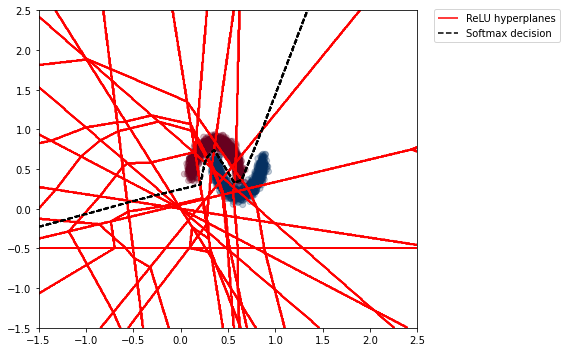

In [27]:
plot_decision_boundaries(model, X_train, y_train, n_pts=500, xlim=[-1, 2], ylim=[-1, 2])

## Prune ReLUs

In [65]:
for i in range(len(model.layers) - 1):
    for j in range(model.layers[i].units):
        model.layers[i].activations[j] = tf.keras.activations.relu

internal_rep = model2internal_rep(model, X_train)
relu_sep = (internal_rep.sum(0) - X_train.shape[0] / 2) / X_train.shape[0]
prune_order = np.argsort(-np.abs(relu_sep))
relu_layers = np.hstack([[i]*model.layers[i].units for i in range(len(model.layers) - 1)])

Test Accuracy=1.00, n_ReLUs=20


<ipython-input-9-db6b2c4ece2d>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


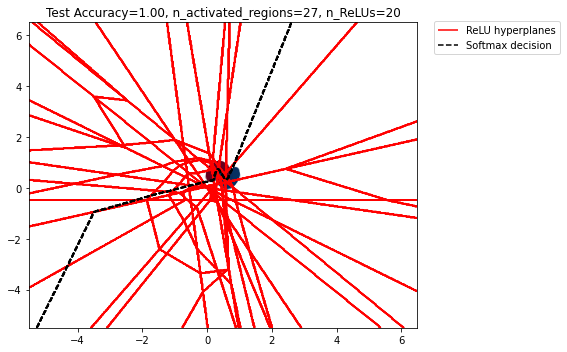

0: layer=0 relu_index=0


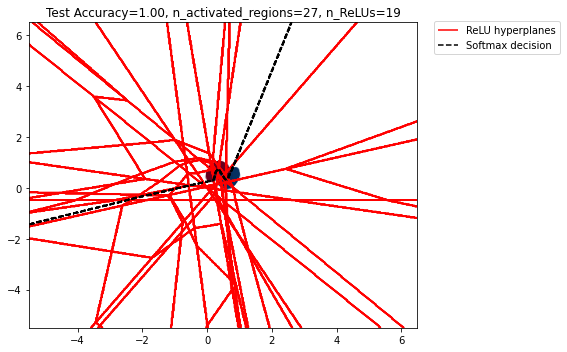

1: layer=1 relu_index=5


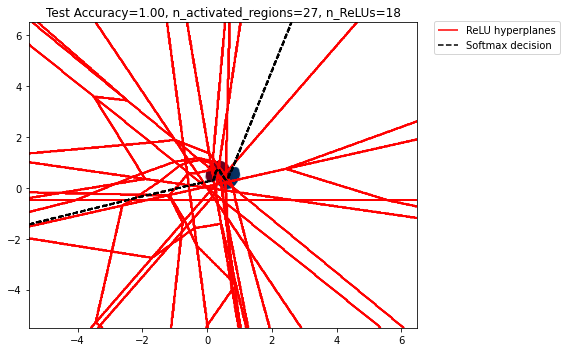

2: layer=1 relu_index=1


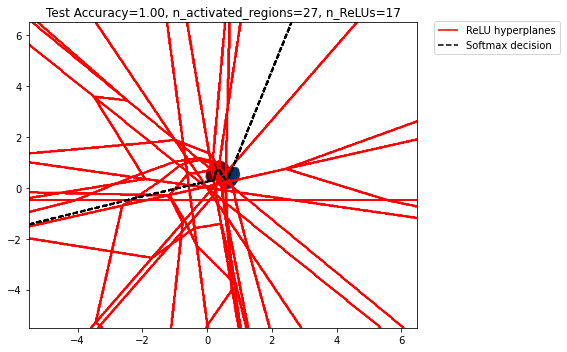

3: layer=1 relu_index=0


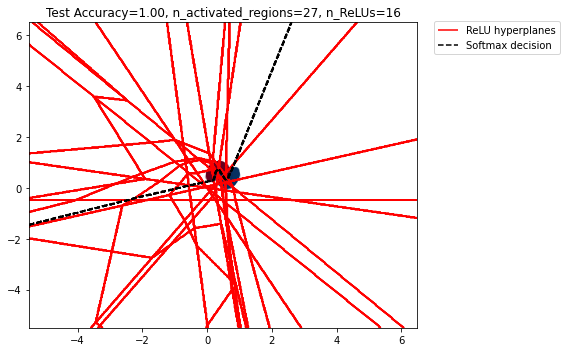

4: layer=0 relu_index=8


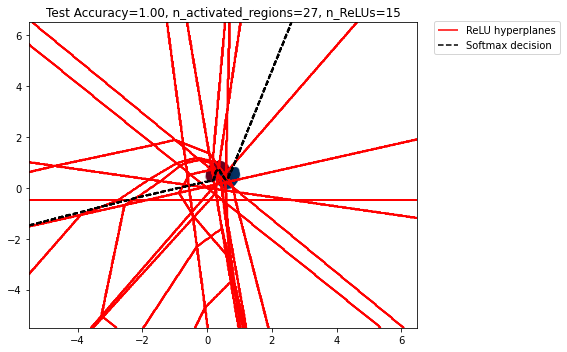

5: layer=1 relu_index=9


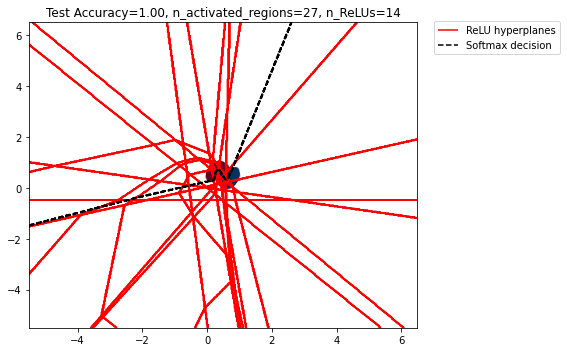

6: layer=0 relu_index=4


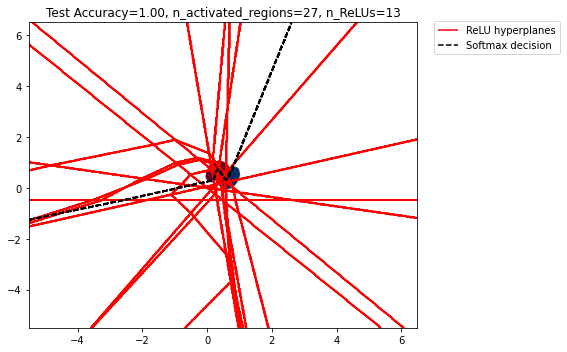

7: layer=0 relu_index=3


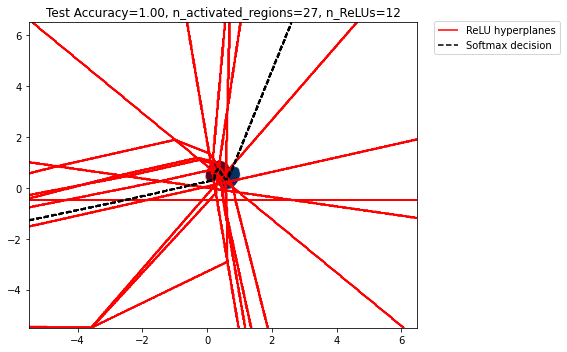

8: layer=0 relu_index=1


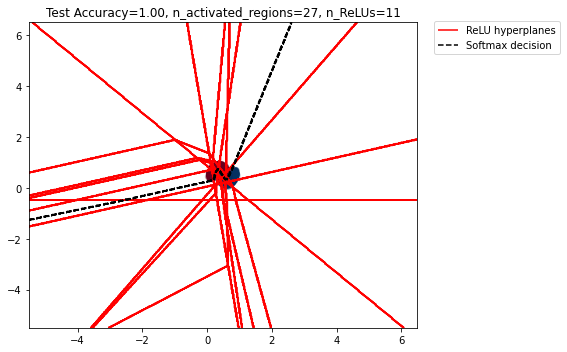

9: layer=0 relu_index=5


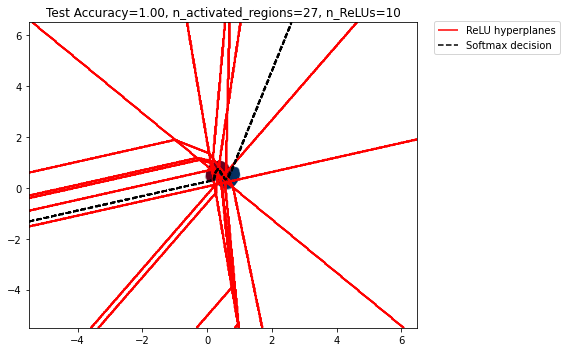

10: layer=1 relu_index=3


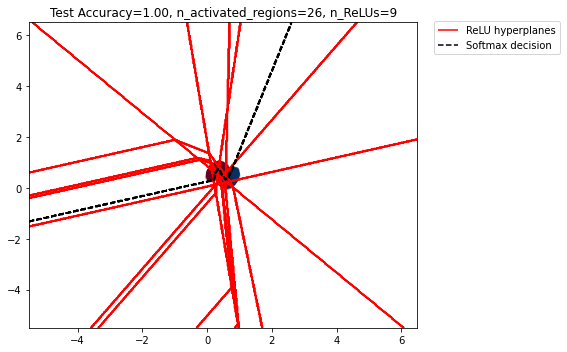

11: layer=0 relu_index=6


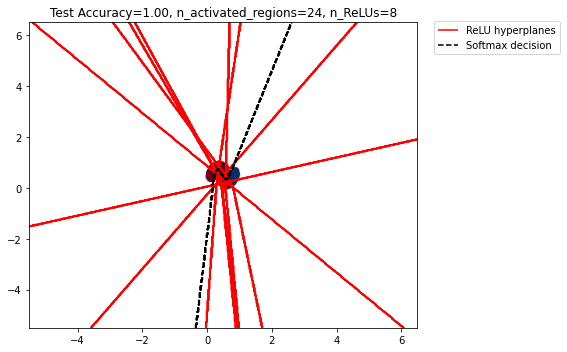

12: layer=0 relu_index=7


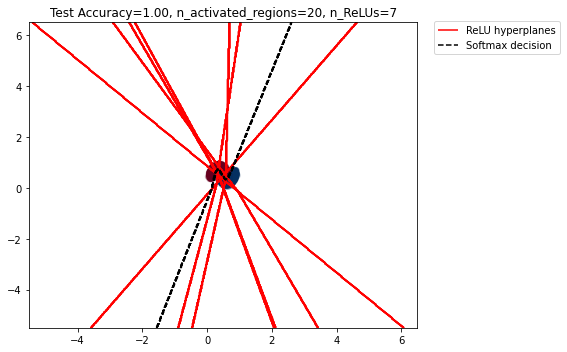

13: layer=1 relu_index=7


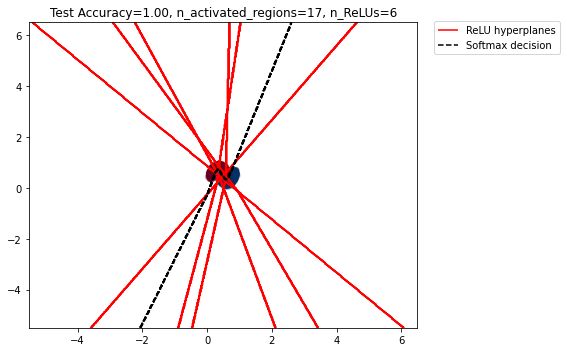

14: layer=1 relu_index=8


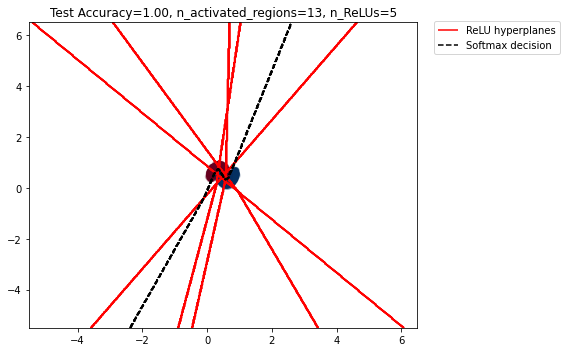

15: layer=1 relu_index=4


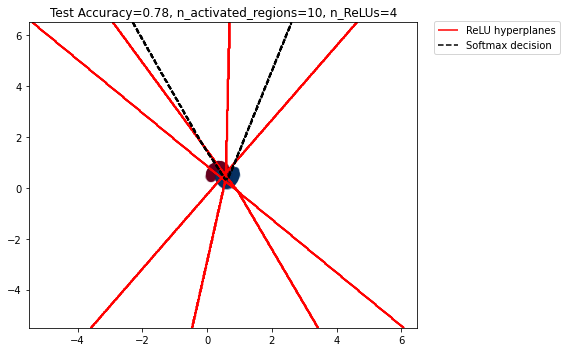

16: layer=0 relu_index=2


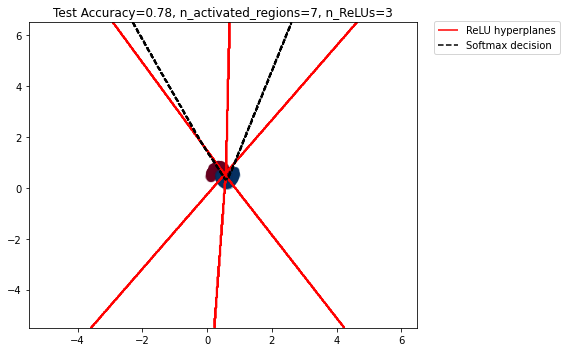

17: layer=1 relu_index=6


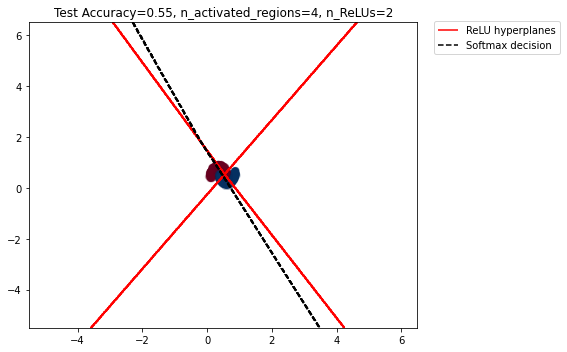

18: layer=1 relu_index=2


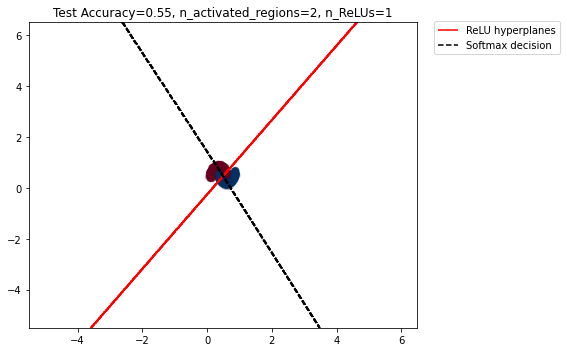

19: layer=0 relu_index=9


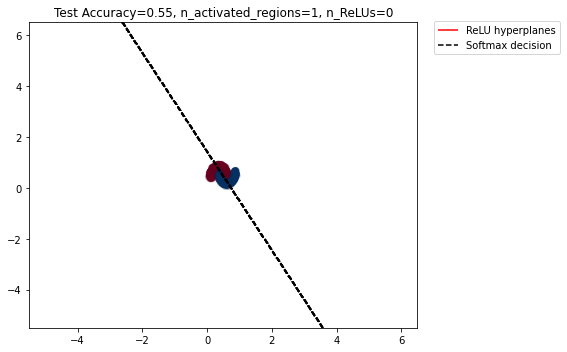

In [68]:
xlim=[-5, 6]; ylim=[-5, 6]
# Reset
for i in range(len(model.layers) - 1):
    for j in range(model.layers[i].units):
        model.layers[i].activations[j] = tf.keras.activations.relu

y_pred = np.argmax(brute_predict(model, X_test), axis=1)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy={test_accuracy:.2f}, n_ReLUs={len(prune_order)}')

n_activated_regions = np.unique(internal_rep, axis=0).shape[0]
plot_decision_boundaries(
    model, X_train, y_train, n_pts=500,
    xlim=xlim, ylim=ylim,
    title=f'Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}, n_ReLUs={len(prune_order)}',
    save_path=f'./results/spiral_layers=2_hyperplanes_relus={len(prune_order)}.png'
)

# Plot
for count, idx in enumerate(prune_order):
    n_activated_regions = np.unique(internal_rep[:, prune_order[count+1:]], axis=0).shape[0]
    if relu_sep[idx] < 0:
        activation = zero_activation
    else:
        activation = tf.keras.activations.linear
    layer_idx = relu_layers[idx]
    relu_in_layer_idx = idx - sum([l.units for l in model.layers[:layer_idx]])
    print(f'{count}:', f'layer={layer_idx}', f'relu_index={relu_in_layer_idx}')
    model.layers[layer_idx].activations[relu_in_layer_idx] = activation

    y_pred = np.argmax(brute_predict(model, X_test), axis=1)
    test_accuracy = np.mean(y_pred == y_test)

    plot_decision_boundaries(
        model, X_train, y_train, n_pts=500,
        xlim=xlim, ylim=ylim,
        title=f'Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}, n_ReLUs={len(prune_order)-count-1}',
        save_path=f'./results/spiral_layers=2_hyperplanes_relus={len(prune_order)-count-1}.png')

Full model
Test Accuracy=1.00, n_ReLUs=20


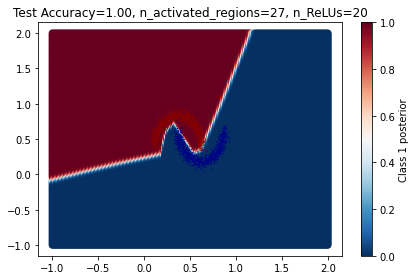

0: layer=0 relu_index=0


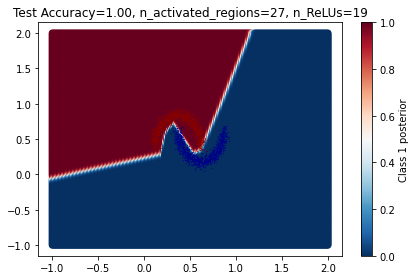

1: layer=1 relu_index=5


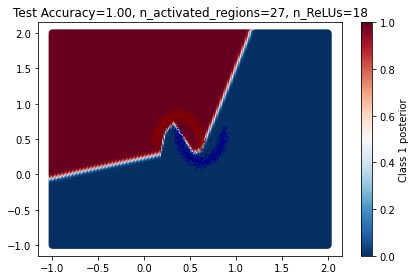

2: layer=1 relu_index=1


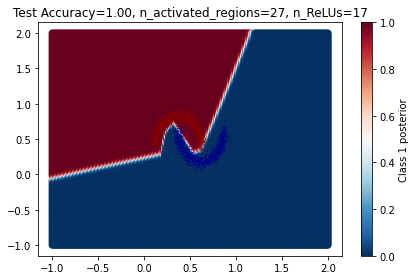

3: layer=1 relu_index=0


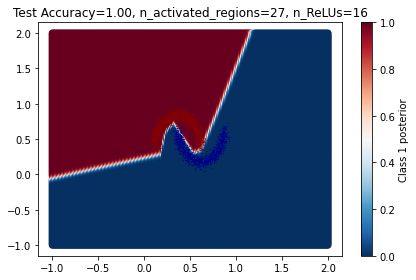

4: layer=0 relu_index=8


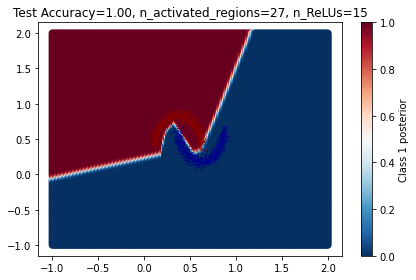

5: layer=1 relu_index=9


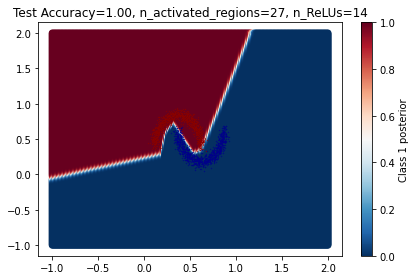

6: layer=0 relu_index=4


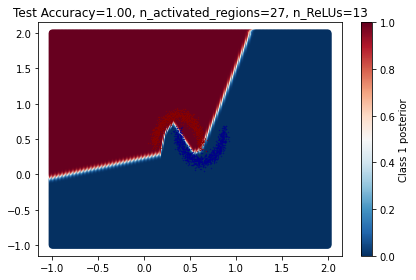

7: layer=0 relu_index=3


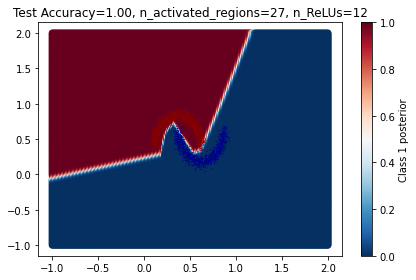

8: layer=0 relu_index=1


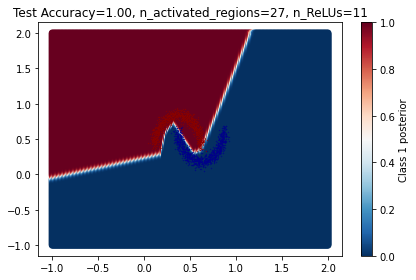

9: layer=0 relu_index=5


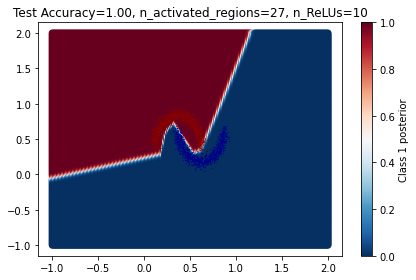

10: layer=1 relu_index=3


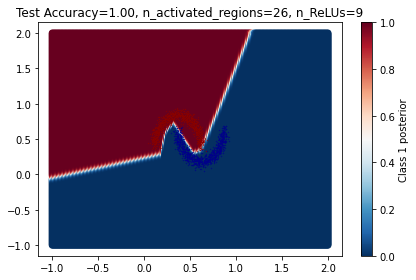

11: layer=0 relu_index=6


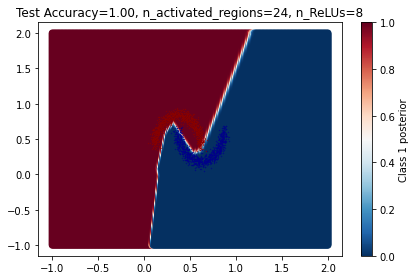

12: layer=0 relu_index=7


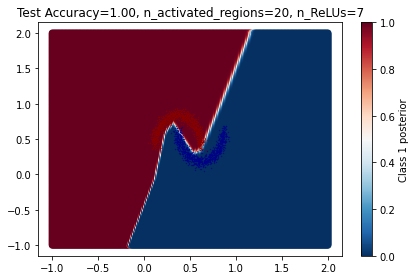

13: layer=1 relu_index=7


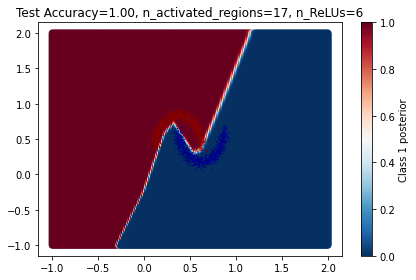

14: layer=1 relu_index=8


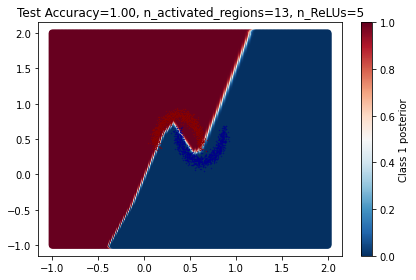

15: layer=1 relu_index=4


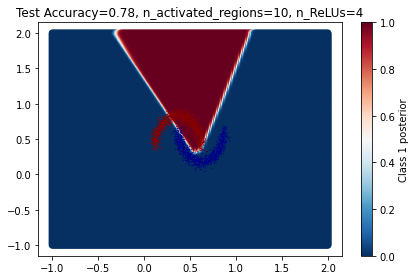

16: layer=0 relu_index=2


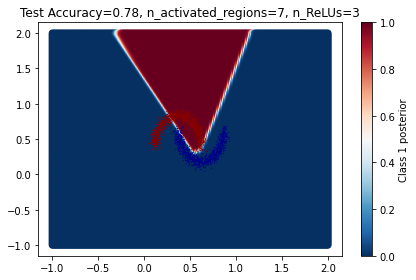

17: layer=1 relu_index=6


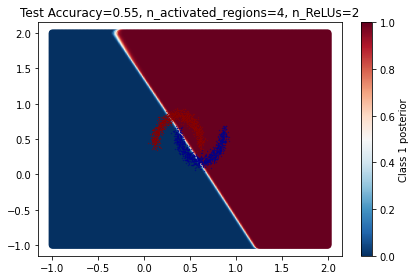

18: layer=1 relu_index=2


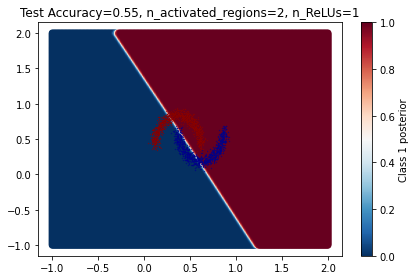

19: layer=0 relu_index=9


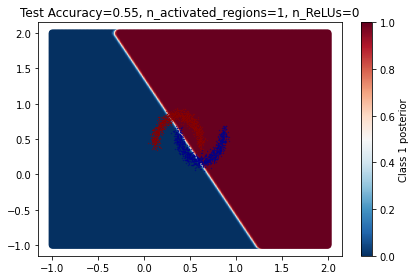

In [70]:
from matplotlib import colors
norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

# Reset
for i in range(len(model.layers) - 1):
    for j in range(model.layers[i].units):
        model.layers[i].activations[j] = tf.keras.activations.relu
print('Full model')
y_pred = np.argmax(brute_predict(model, X_test), axis=1)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy={test_accuracy:.2f}, n_ReLUs={len(prune_order)}')
# plot_decision_boundaries(model, X_train, y_train, n_pts=250)
xlim = [-1, 2]
ylim = [-1, 2]
n_pts = 200
n_activated_regions = np.unique(internal_rep, axis=0).shape[0]

xx = np.linspace(xlim[0], xlim[1], n_pts)
yy = np.linspace(ylim[0], ylim[1], n_pts)
YY, XX = np.meshgrid(yy, xx)
XY = np.vstack([XX.ravel(), YY.ravel()]).T

probs = brute_predict(model, XY)

z_plot = probs[:, 0].reshape(XX.shape)

plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r', norm=norm)
plt.colorbar(label='Class 1 posterior')

colors = ['darkred', 'darkblue']
for label in np.unique(y_train):
    idx = np.where(y_train == label)[0]
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=label, c=colors[label], s=0.1)

    
plt.title(f'Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}, n_ReLUs={len(prune_order)}')
plt.tight_layout()
plt.savefig(f'./results/spiral_layers=2_heatmap_relus={len(prune_order)}.png')
plt.show()

# Plot
for count, idx in enumerate(prune_order):
    n_activated_regions = np.unique(internal_rep[:, prune_order[count+1:]], axis=0).shape[0]
    if relu_sep[idx] < 0:
        activation = zero_activation
    else:
        activation = tf.keras.activations.linear
    layer_idx = relu_layers[idx]
    relu_in_layer_idx = idx - sum([l.units for l in model.layers[:layer_idx]])
    print(f'{count}:', f'layer={layer_idx}', f'relu_index={relu_in_layer_idx}')
    model.layers[layer_idx].activations[relu_in_layer_idx] = activation

    y_pred = np.argmax(brute_predict(model, X_test), axis=1)
    test_accuracy = np.mean(y_pred == y_test)

    # plot_decision_boundaries(model, X_train, y_train, n_pts=250)
    xlim = [-1, 2]
    ylim = [-1, 2]
    n_pts = 200

    xx = np.linspace(xlim[0], xlim[1], n_pts)
    yy = np.linspace(ylim[0], ylim[1], n_pts)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    probs = brute_predict(model, XY)

    z_plot = probs[:, 0].reshape(XX.shape)

    plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r', norm=norm)
    plt.colorbar(label='Class 1 posterior')
    
    colors = ['darkred', 'darkblue']
    for label in np.unique(y_train):
        idx = np.where(y_train == label)[0]
        plt.scatter(X_train[idx, 0], X_train[idx, 1], label=label, c=colors[label], s=0.1)

    plt.title(f'Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}, n_ReLUs={len(prune_order)-count-1}')
    plt.tight_layout()
    plt.savefig(f'./results/spiral_layers=2_heatmap_relus={len(prune_order)-count-1}.png')
    plt.show()

In [ ]:
prune_order = np.argsort(-np.abs(relu_sep))

all_relus_

for purity in np.linspace(0.5 + 0.5 / res, 0, res+2):
    results['relu_hyperplane_balance'].append(1 - purity*2)
    
    prune_delete_edge = np.where(model_results['separation_frac'] <= -purity)[0]
    prune_delete_relu = np.where(model_results['separation_frac'] >= purity)[0]
    results['n_relus'].append(n_units - len(prune_delete_edge) - len(prune_delete_relu))
    
    # Prune relus that are always off
    prune_diag = np.ones(n_units).astype('float32')
    prune_diag[prune_delete_edge] = 0
    model.layers[1].connections = tf.constant(tf.linalg.diag(prune_diag))
    
    # Prune relus that are always on
    for idx in (prune_delete_relu):
        model.layers[1].activations[idx] = eye_activation
        
    active_relu_indices = np.setdiff1d(np.arange(n_units), np.concatenate((prune_delete_relu, prune_delete_edge)))
    evalues = evalues_from_regions(model_results['internal_rep'][:, active_relu_indices])
    results['n_activated_regions'].append(sum(evalues > 0))
        
    test_results = eval_model(model, metric, ds_test)
    for key, val in test_results.items():
        results['test_' + key].append(val)
        
    train_results = eval_model(model, metric, ds_train)
    for key, val in train_results.items():
        results['train_' + key].append(val)

In [137]:
xlim = [-1, 2]
ylim = [-1, 2]
n_pts = 200

xx = np.linspace(xlim[0], xlim[1], n_pts)
yy = np.linspace(ylim[0], ylim[1], n_pts)
YY, XX = np.meshgrid(yy, xx)
XY = np.vstack([XX.ravel(), YY.ravel()]).T

probs = model.predict(XY)

z_plot = probs[:, 0].reshape(XX.shape)

plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r')
plt.show()

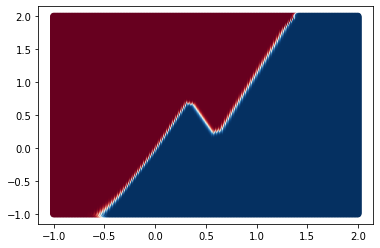

In [79]:
from mpl_toolkits import mplot3d

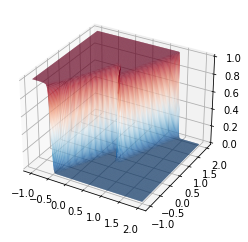

In [80]:
ax = plt.axes(projection='3d')
ax.plot_surface(XX, YY, z_plot, rstride=1, cstride=1,
                cmap='RdBu_r', edgecolor='none')
plt.show()